# NIRCam PSF Photometry With Space_Phot

**Author**: Ori Fox
<br>
**Last Updated**: August, 2023

## Table of contents
1. [Introduction](#intro)<br>
2. [Setup](#setup)<br>
    2.1 [Python imports](#py_imports)<br>
    2.2 [Download data](#bso4)<br>
3. [Bright, Single Object](#bso)<br>
    3.1 [Multiple, Level2 Files](#bso2)<br>
4. [Faint/Upper Limit, Single Object](#fso)<br>
    4.1 [Multiple, Level2 Files](#fso2)<br>
5. [Stellar Field (LMC)](#lmv)<br>
    5.1 [Multiple, Level2 Files](#lmc2)<br>
    5.2 [Single, Level3 Mosaicked File](#lmc3)<br>

1.<font color='white'>-</font>Introduction <a class="anchor" id="intro"></a>
------------------

**Packages to Install**:
drizzlepac\\
space_phot https://github.com/jpierel14/space_phot\\
photutils (on main git+https://github.com/astropy/photutils)\\
jupyter\\

**Goals**: 

PSF Photometry can be obtained using:

* grid of PSF models from WebbPSF
* single effective PSF (ePSF) NOT YET AVAILABLE
* grid of effective PSF NOT YET AVAILABLE

The notebook shows:

* how to obtain the PSF model from WebbPSF (or build an ePSF)
* how to perform PS
* photometry on the image

2.<font color='white'>-</font>Setup <a class="anchor" id="setup"></a>
------------------

### 2.1<font color='white'>-</font>Python imports<a class="anchor" id="py_imports"></a> ###

In [1]:
from astropy.io import fits
from astropy.nddata import extract_array
from astropy.coordinates import SkyCoord
from astropy import wcs
from astropy.wcs.utils import skycoord_to_pixel
from astropy import units as u
import numpy as np
import pandas as pd
from astropy.visualization import simple_norm
from urllib.parse import urlparse
import requests
import time
import math
import logging
from jwst.associations import load_asn
import matplotlib.pyplot as plt
%matplotlib inline

from astroquery.mast import Observations
import os
import tarfile

# Background and PSF Functions
from photutils.background import MMMBackground, MADStdBackgroundRMS
from photutils.detection import DAOStarFinder

import space_phot
from importlib.metadata import version
version('space_phot')



The following task in the stsci.skypac package can be run with TEAL:
                                    skymatch                                    


The following tasks in the drizzlepac package can be run with TEAL:
    astrodrizzle       config_testbed      imagefindpars           mapreg       
       photeq            pixreplace           pixtopix            pixtosky      
  refimagefindpars       resetbits          runastrodriz          skytopix      
     tweakback            tweakreg           updatenpol


'0.2.5'

### 2.2<font color='white'>-</font>Download data<a class="anchor" id="bso4"></a> ###

In [2]:
# Download NIRCam Data PID 1537 (Calibration Program) and NIRCam Data PID 1476 (LMC)
files_to_download = [
    'jw01537-o024_t001_nircam_clear-f444w-sub160_i2d.fits',
    'jw01537-o024_20241003t130922_image3_00001_asn.json',
    'jw01537024001_0310a_00001_nrcblong_cal.fits',
    'jw01537024001_0310a_00002_nrcblong_cal.fits',
    'jw01537024001_0310a_00003_nrcblong_cal.fits',
    'jw01537024001_0310a_00004_nrcblong_cal.fits',
    'jw01537024001_0310k_00001_nrcblong_cal.fits',
    'jw01537024001_0310k_00002_nrcblong_cal.fits',
    'jw01537024001_0310k_00003_nrcblong_cal.fits',
    'jw01537024001_0310k_00004_nrcblong_cal.fits',
    'jw01476-o001_t001_nircam_clear-f150w_i2d.fits',
    'jw01476-o001_20240910t004333_image3_00023_asn.json',
    'jw01476001007_02101_00001_nrca1_cal.fits',
    'jw01476001007_02101_00002_nrca1_cal.fits',
    'jw01476001007_02101_00003_nrca1_cal.fits',
    'jw01476001008_02101_00001_nrca1_cal.fits',
    'jw01476001008_02101_00002_nrca1_cal.fits',
    'jw01476001008_02101_00003_nrca1_cal.fits',
    'jw01476001008_02101_00004_nrca1_cal.fits',
    'jw01476001008_02101_00005_nrca1_cal.fits',
    'jw01476001008_02101_00006_nrca1_cal.fits'
]


def download_files(files_to_download):
    for file in files_to_download:
        # Check if the file already exists in the current working directory
        if os.path.exists(file):
            print(f"File {file} already exists. Skipping download.")
            continue
        cal_uri = f'mast:JWST/product/{file}'
        Observations.download_file(cal_uri)


# Call the function to download files
download_files(files_to_download)

 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


3.<font color='white'>-</font>Bright, Single Object<a class="anchor" id="bso"></a>
------------------

### 3.1<font color='white'>-</font>Multiple, Level2 Files<a class="anchor" id="bso2"></a> ###

In [3]:
# Level 3 Files: NIRCam Data PID 1537 (Calibration Program):
lvl3 = 'jw01537-o024_t001_nircam_clear-f444w-sub160_i2d.fits'
lvl3

'jw01537-o024_t001_nircam_clear-f444w-sub160_i2d.fits'

In [4]:
hdl = fits.open(lvl3)
hdr = hdl[0].header
asnfile = hdr['ASNTABLE']
lvl2_prelim = []
asn_data = load_asn(open(asnfile))
for member in asn_data['products'][0]['members']:
    #print(member['expname'])
    lvl2_prelim.append(member['expname'])
    
lvl2_prelim

['jw01537024001_0310a_00001_nrcblong_cal.fits',
 'jw01537024001_0310a_00002_nrcblong_cal.fits',
 'jw01537024001_0310a_00003_nrcblong_cal.fits',
 'jw01537024001_0310a_00004_nrcblong_cal.fits',
 'jw01537024001_0310k_00001_nrcblong_cal.fits',
 'jw01537024001_0310k_00002_nrcblong_cal.fits',
 'jw01537024001_0310k_00003_nrcblong_cal.fits',
 'jw01537024001_0310k_00004_nrcblong_cal.fits']

In [5]:
# Sort out LVL2 Data That Includes The Actual Source (there are 4 detectors)
source_location = SkyCoord('5:05:30.6593', '+52:49:49.862', unit=(u.hourangle, u.deg))
lvl2 = []
for ref_image in lvl2_prelim:
    print(ref_image)
    ref_fits = fits.open(ref_image)
    ref_data = fits.open(ref_image)['SCI', 1].data
    ref_y, ref_x = skycoord_to_pixel(source_location, wcs.WCS(ref_fits['SCI', 1], ref_fits))
    print(ref_y, ref_x)
    try:
        extract_array(ref_data, (11, 11), (ref_x, ref_y)) # block raising an exception
    except Exception as e:
        logging.error(f"An error occurred: {e}")
        pass  # Doing nothing on exception, but logging it
    else:
        lvl2.append(ref_image)
        print(ref_image + ' added to final list')
        
lvl2

jw01537024001_0310a_00001_nrcblong_cal.fits
18.326534497363575 27.792574724663417
jw01537024001_0310a_00001_nrcblong_cal.fits added to final list
jw01537024001_0310a_00002_nrcblong_cal.fits
21.954480631265525 30.421508304425142
jw01537024001_0310a_00002_nrcblong_cal.fits added to final list
jw01537024001_0310a_00003_nrcblong_cal.fits
15.006032247745697 122.74611417016888
jw01537024001_0310a_00003_nrcblong_cal.fits added to final list
jw01537024001_0310a_00004_nrcblong_cal.fits
18.706715994744766 125.3867237350042
jw01537024001_0310a_00004_nrcblong_cal.fits added to final list
jw01537024001_0310k_00001_nrcblong_cal.fits
138.37946599860112 27.696884933380467
jw01537024001_0310k_00001_nrcblong_cal.fits added to final list
jw01537024001_0310k_00002_nrcblong_cal.fits
141.96642008764647 30.31774437710774
jw01537024001_0310k_00002_nrcblong_cal.fits added to final list
jw01537024001_0310k_00003_nrcblong_cal.fits
135.29495696337315 122.69274633004643
jw01537024001_0310k_00003_nrcblong_cal.fits 

['jw01537024001_0310a_00001_nrcblong_cal.fits',
 'jw01537024001_0310a_00002_nrcblong_cal.fits',
 'jw01537024001_0310a_00003_nrcblong_cal.fits',
 'jw01537024001_0310a_00004_nrcblong_cal.fits',
 'jw01537024001_0310k_00001_nrcblong_cal.fits',
 'jw01537024001_0310k_00002_nrcblong_cal.fits',
 'jw01537024001_0310k_00003_nrcblong_cal.fits',
 'jw01537024001_0310k_00004_nrcblong_cal.fits']

In [6]:
# Change all DQ flagged pixels to NANs
for file in lvl2:
    hdul = fits.open(file, mode='update')
    data = fits.open(file)['SCI', 1].data
    dq = fits.open(file)['DQ', 1].data
    data[dq == 1] = np.nan
    hdul['SCI', 1].data = data
    hdul.flush()

jw01537024001_0310a_00001_nrcblong_cal.fits


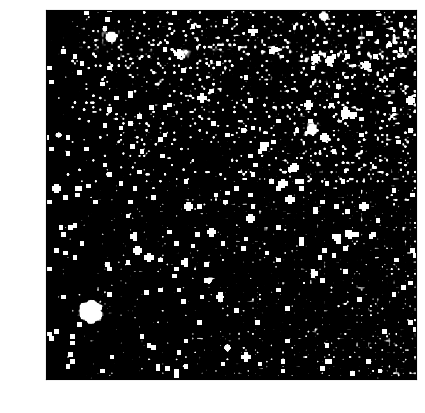

'jw01537024001_0310a_00001_nrcblong_cal.fits'

In [7]:
# Examine the First Image
ref_image = lvl2[0]
print(ref_image)
ref_fits = fits.open(ref_image)
ref_data = fits.open(ref_image)['SCI', 1].data
norm1 = simple_norm(ref_data, stretch='linear', min_cut=-1, max_cut=10)

plt.imshow(ref_data, origin='lower', norm=norm1, cmap='gray')
plt.gca().tick_params(labelcolor='none', axis='both', color='none')
plt.show()
lvl2[0]

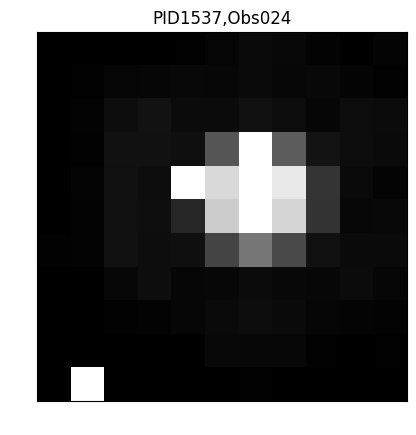

array([[-1.39843893e+01,             nan, -7.10014486e+00,
        -1.18051510e+01, -1.22078762e+01, -7.55733681e+00,
        -2.13549590e+00, -8.03505421e+00, -1.20125780e+01,
        -7.57162142e+00, -1.40897741e+01],
       [-8.80824947e+00, -1.50944538e+01, -8.38607407e+00,
        -1.30650015e+01, -6.26623774e+00,  2.16780949e+01,
         1.93335018e+01,  1.84923229e+01, -2.38547111e+00,
        -8.05991173e+00, -3.66179228e+00],
       [-8.69729900e+00, -1.05824366e+01, -1.91644752e+00,
         2.23856020e+00,  1.58385477e+01,  2.87495098e+01,
         3.98870125e+01,  3.08072701e+01,  1.16344948e+01,
         8.19910336e+00,  4.62944794e+00],
       [-1.64087601e+01, -8.50557709e+00,  2.11503353e+01,
         4.15567169e+01,  1.49958334e+01,  2.04633923e+01,
         3.47761116e+01,  2.32894917e+01,  1.85810509e+01,
         3.45461349e+01,  1.56002789e+01],
       [ 2.63730697e-02,  2.83913875e+00,  5.49829063e+01,
         4.31866798e+01,  4.97716103e+01,  2.61053589e+02,
  

In [8]:
# Zoom in to see the source
ref_y, ref_x = skycoord_to_pixel(source_location, wcs.WCS(ref_fits['SCI', 1], ref_fits))
ref_cutout = extract_array(ref_data, (11, 11), (ref_x, ref_y))
norm1 = simple_norm(ref_cutout, stretch='linear', min_cut=-10, max_cut=1000)
plt.imshow(ref_cutout, origin='lower',
           norm=norm1, cmap='gray')
plt.title('PID1537,Obs024')
plt.gca().tick_params(labelcolor='none', axis='both', color='none')
plt.show()

ref_cutout

Setting up sim to match jw01537024001_0310a_00001_nrcblong_cal.fits



MAST OPD query around UTC: 2022-09-08T10:35:01.135
                        MJD: 59830.44098535879

OPD immediately preceding the given datetime:
	URI:	 mast:JWST/product/O2022090801-NRCA3_FP1-1.fits
	Date (MJD):	 59829.7994
	Delta time:	 -0.6416 days

OPD immediately following the given datetime:
	URI:	 mast:JWST/product/R2022090902-NRCA3_FP1-1.fits
	Date (MJD):	 59831.6680
	Delta time:	 1.2270 days
User requested choosing OPD time closest in time to 2022-09-08T10:35:01.135, which is O2022090801-NRCA3_FP1-1.fits, delta time -0.642 days

 [Done]


Importing and format-converting OPD from ./webbpsf-data/webbpsf-data/MAST_JWST_WSS_OPDs/O2022090801-NRCA3_FP1-1.fits
Backing out SI WFE and OTE field dependence at the WF sensing field point



Configured simulation instrument for:
    Instrument: NIRCam
    Filter: F444W
    Detector: NRCB5
    Apername: NRCB5_SUB160
    Det. Pos.: (80, 80) in subarray
    Image plane mask: None
    Pupil plane mask: None
    

Running instrument: NIRCam, filter: F444W
  Running detector: NRCB5
    Position 1/1: (array(27.79257472), array(18.3265345)) pixels


    Position 1/1 centroid: (121.61408244887103, 121.20038830234279)

Running instrument: NIRCam, filter: F444W
  Running detector: NRCB5
    Position 1/1: (array(30.4215083), array(21.95448063)) pixels


    Position 1/1 centroid: (121.61425824086716, 121.20033209102951)

Running instrument: NIRCam, filter: F444W
  Running detector: NRCB5
    Position 1/1: (array(122.74611417), array(15.00603225)) pixels


    Position 1/1 centroid: (121.61464275122991, 121.20874936410743)

Running instrument: NIRCam, filter: F444W
  Running detector: NRCB5
    Position 1/1: (array(125.38672374), array(18.70671599)) pixels


    Position 1/1 centroid: (121.61474547983791, 121.20894011410664)

Running instrument: NIRCam, filter: F444W
  Running detector: NRCB5
    Position 1/1: (array(27.69688493), array(138.379466)) pixels


    Position 1/1 centroid: (121.62031321487149, 121.19555321077925)

Running instrument: NIRCam, filter: F444W
  Running detector: NRCB5
    Position 1/1: (array(30.31774438), array(141.96642009)) pixels


    Position 1/1 centroid: (121.62027405671115, 121.19573665868678)

Running instrument: NIRCam, filter: F444W
  Running detector: NRCB5
    Position 1/1: (array(122.69274633), array(135.29495696)) pixels


    Position 1/1 centroid: (121.61911751843284, 121.20667407178158)

Running instrument: NIRCam, filter: F444W
  Running detector: NRCB5
    Position 1/1: (array(125.31935628), array(138.93182751)) pixels


    Position 1/1 centroid: (121.61907288725097, 121.20713425404828)


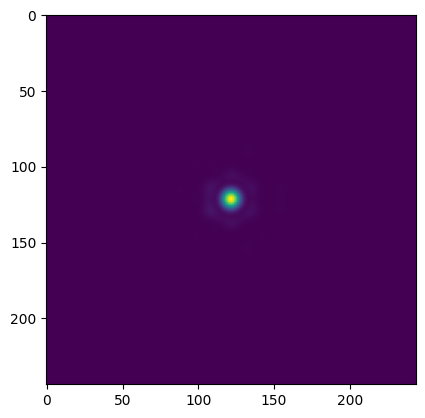

In [9]:
# Set environmental variables
os.environ["WEBBPSF_PATH"] = "./webbpsf-data/webbpsf-data"
os.environ["PYSYN_CDBS"] = "./grp/redcat/trds/"

# required webbpsf data
boxlink = 'https://stsci.box.com/shared/static/qxpiaxsjwo15ml6m4pkhtk36c9jgj70k.gz'                                                          
boxfile = './webbpsf-data/webbpsf-data-LATEST.tar.gz'
synphot_url = 'http://ssb.stsci.edu/trds/tarfiles/synphot5.tar.gz'
synphot_file = './synphot5.tar.gz'

webbpsf_folder = './webbpsf-data'
synphot_folder = './grp'


def download_file(url, dest_path, timeout=60):
    parsed_url = urlparse(url)
    if parsed_url.scheme not in ["http", "https"]:
        raise ValueError(f"Unsupported URL scheme: {parsed_url.scheme}")

    response = requests.get(url, stream=True, timeout=timeout)
    response.raise_for_status()
    with open(dest_path, "wb") as f:
        for chunk in response.iter_content(chunk_size=8192):
            f.write(chunk)


# Gather webbpsf files
psfExist = os.path.exists(webbpsf_folder)
if not psfExist:
    os.makedirs(webbpsf_folder)
    download_file(boxlink, boxfile)
    gzf = tarfile.open(boxfile)
    gzf.extractall(webbpsf_folder, filter='data')

# Gather synphot files
synExist = os.path.exists(synphot_folder)
if not synExist:
    os.makedirs(synphot_folder)
    download_file(synphot_url, synphot_file)
    gzf = tarfile.open(synphot_file)
    gzf.extractall('./', filter='data')

# Get PSF from WebbPSF
jwst_obs = space_phot.observation2(lvl2)
psfs = space_phot.get_jwst_psf(jwst_obs, source_location)
plt.imshow(psfs[0].data)
plt.show()

Finished PSF psf_photometry with median residuals of 0.82%


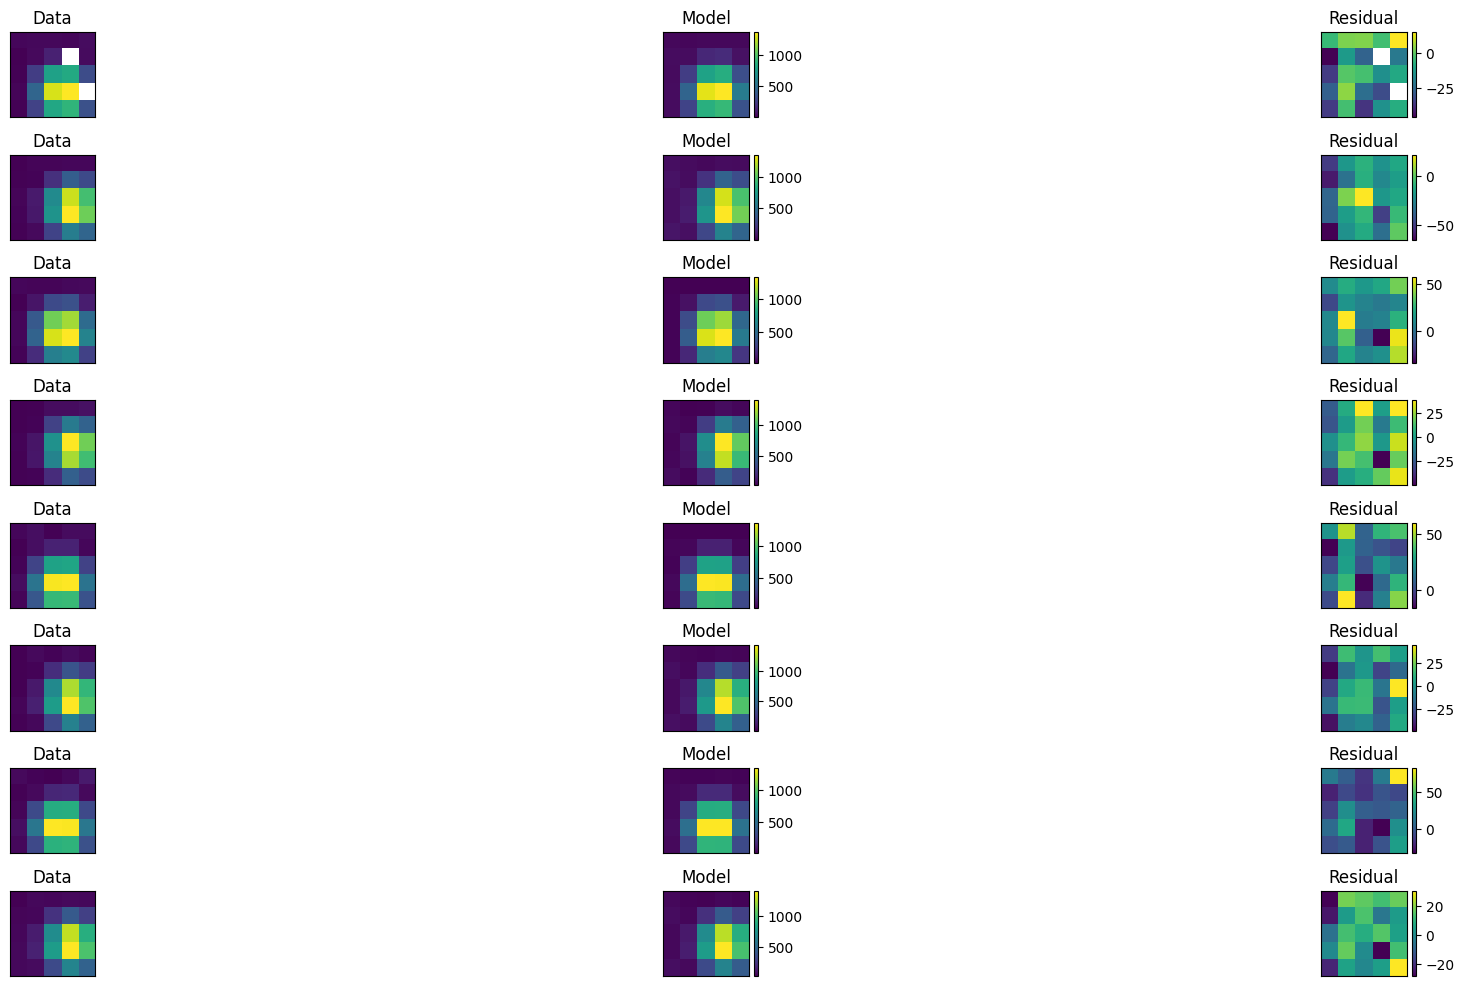

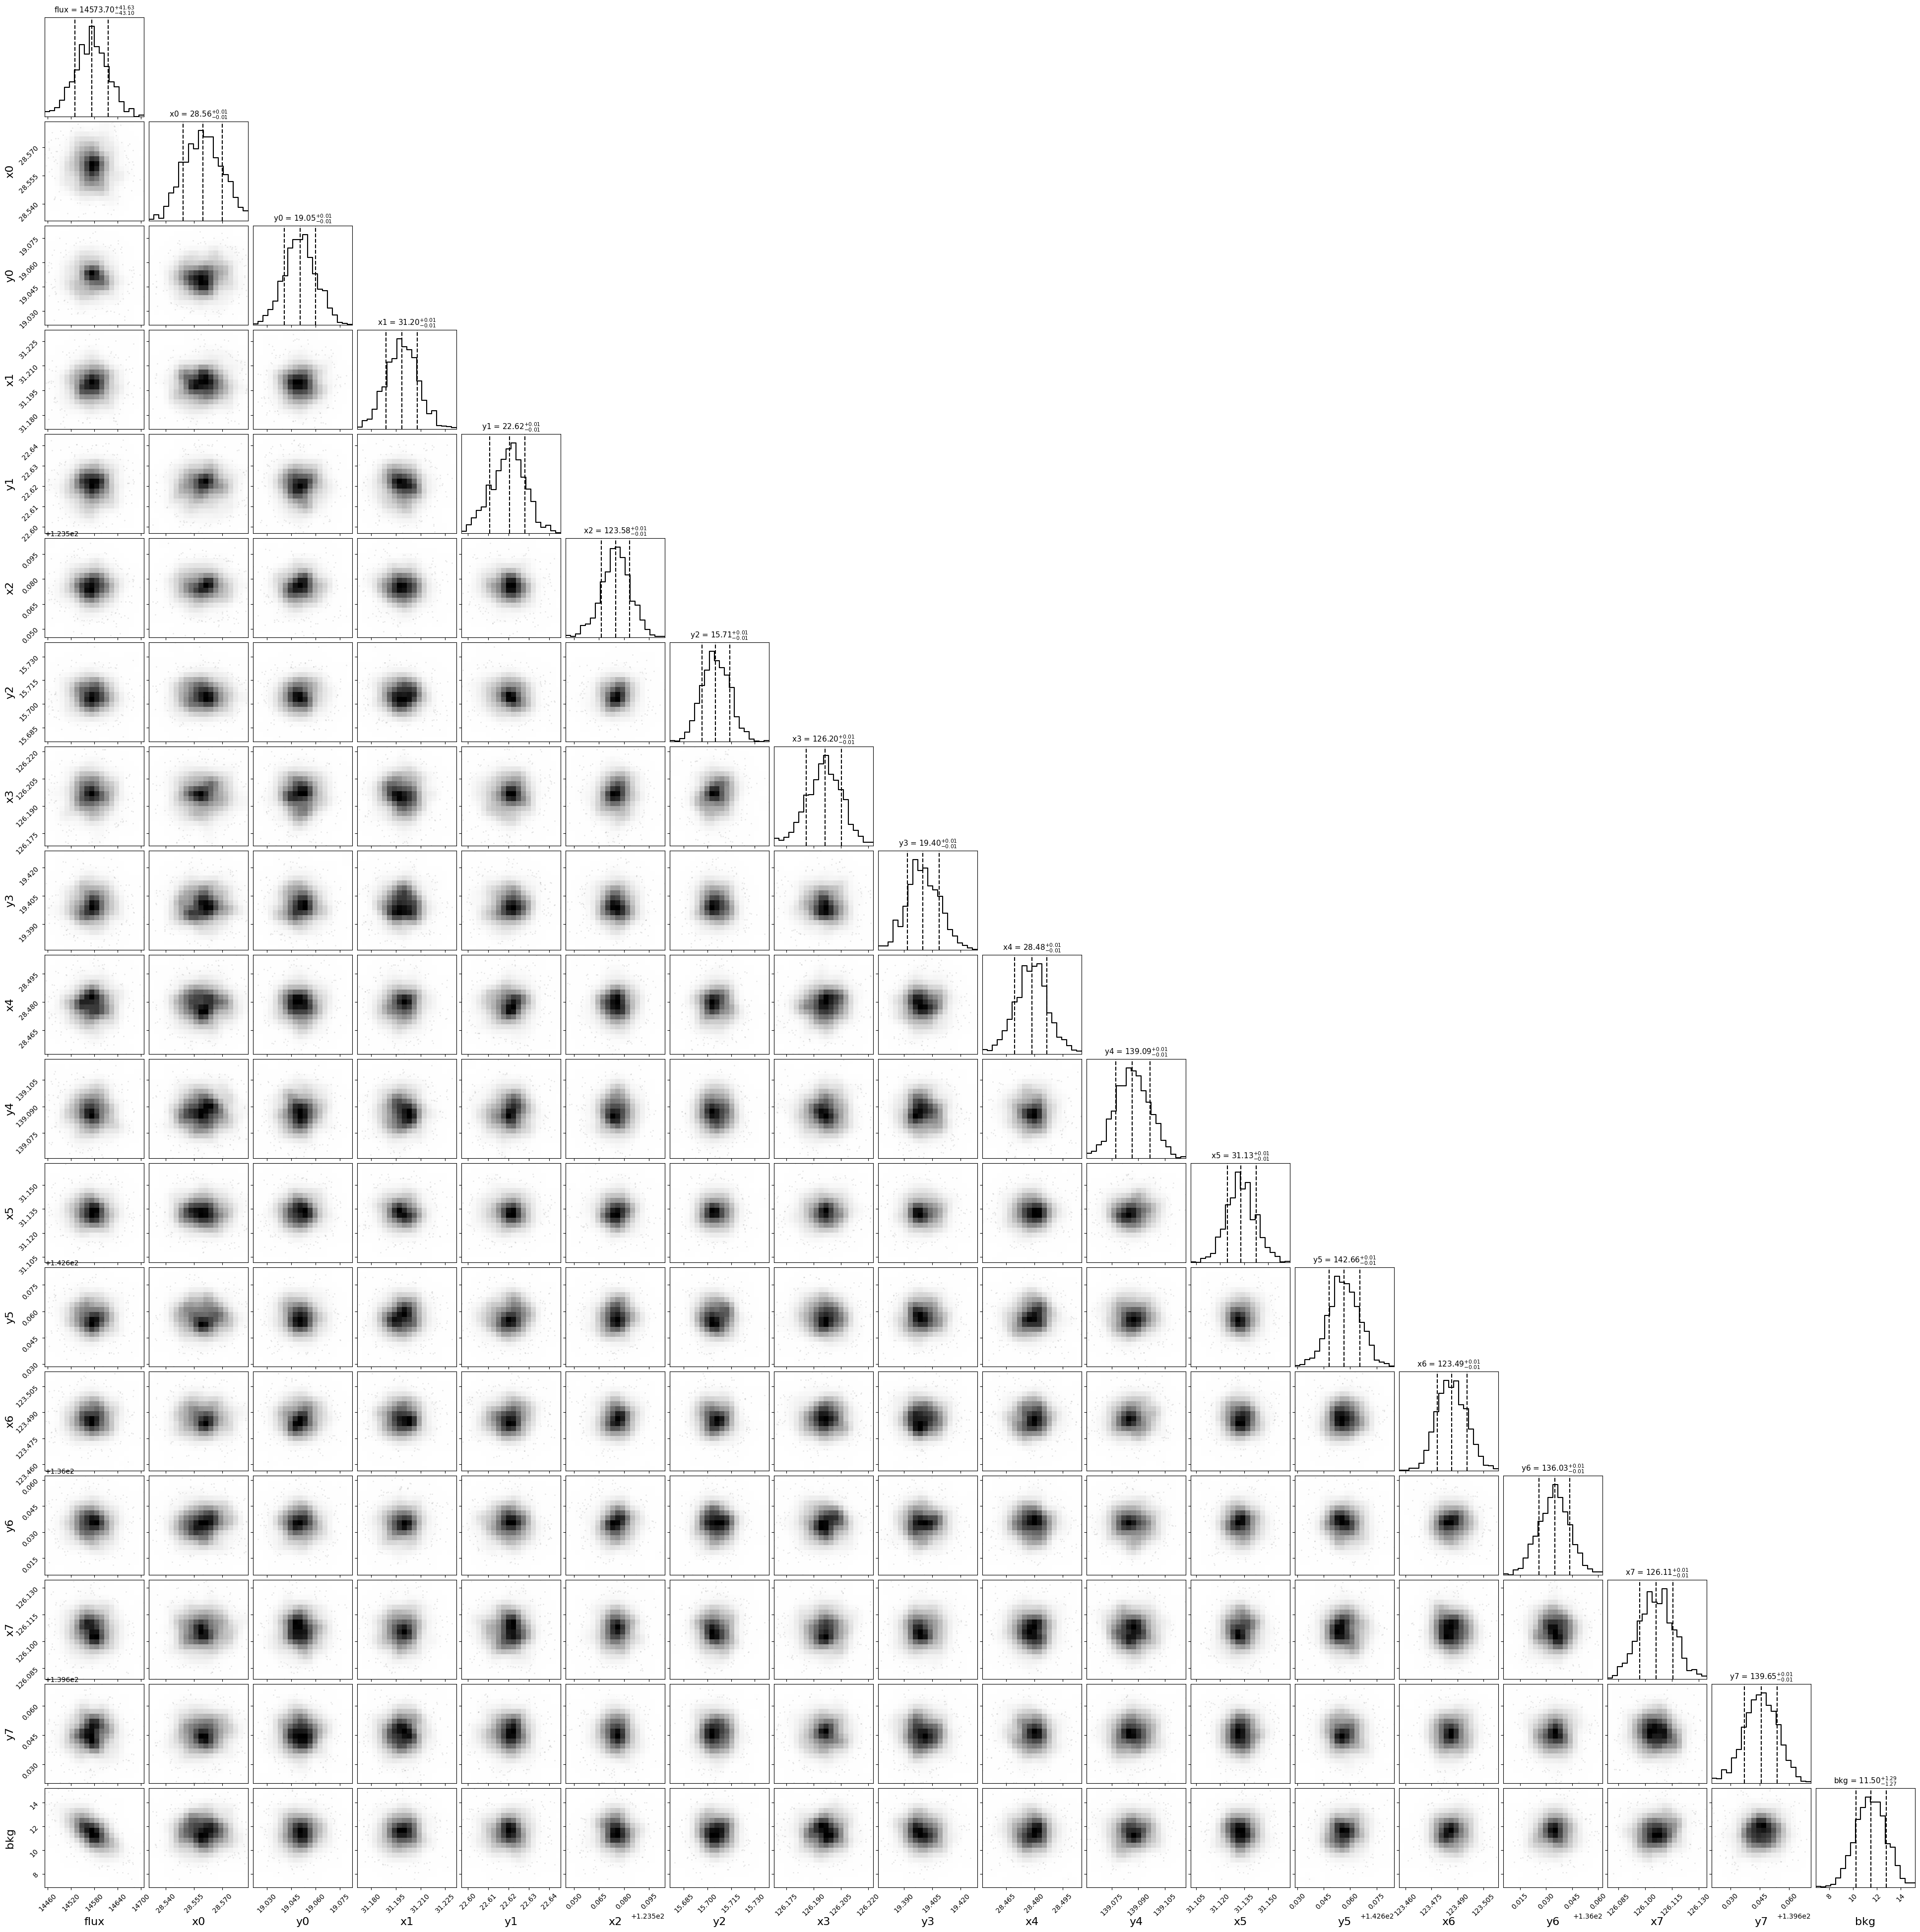

        ra        ...                     exp                    
----------------- ... -------------------------------------------
 76.3777260857907 ... jw01537024001_0310a_00001_nrcblong_cal.fits
76.37772568876217 ... jw01537024001_0310a_00002_nrcblong_cal.fits
76.37772428646588 ... jw01537024001_0310a_00003_nrcblong_cal.fits
76.37772485069628 ... jw01537024001_0310a_00004_nrcblong_cal.fits
76.37772561261627 ... jw01537024001_0310k_00001_nrcblong_cal.fits
76.37772460993881 ... jw01537024001_0310k_00002_nrcblong_cal.fits
  76.377725346437 ... jw01537024001_0310k_00003_nrcblong_cal.fits
76.37772550978903 ... jw01537024001_0310k_00004_nrcblong_cal.fits


In [10]:
# Do PSF Photometry using space_phot (details of fitting are in documentation)
# https://st-phot.readthedocs.io/en/latest/examples/plot_a_psf.html#jwst-images
jwst_obs.psf_photometry(psfs, source_location, bounds={'flux': [-10, 10000],
                        'centroid': [-2, 2],
                        'bkg': [0, 50]},
                        fit_width=5,
                        fit_bkg=True,
                        fit_flux='single')
jwst_obs.plot_psf_fit()
plt.show()

jwst_obs.plot_psf_posterior(minweight=.0005)
plt.show()

print(jwst_obs.psf_result.phot_cal_table)

In [11]:
# Calculate Average Magnitude from Table
mag_arr = jwst_obs.psf_result.phot_cal_table['mag']
magerr_arr = jwst_obs.psf_result.phot_cal_table['magerr']

mag_lvl2psf = np.mean(mag_arr)
magerr_lvl2psf = math.sqrt(sum(p**2 for p in magerr_arr))
print(round(mag_lvl2psf, 4), round(magerr_lvl2psf, 4))

16.0711 0.0093


4.<font color='white'>-</font>Faint/Upper Limit, Single Object<a class="anchor" id="fso"></a>
------------------

### 4.1<font color='white'>-</font>Multiple, Level2 Files<a class="anchor" id="fso2"></a> ###

In [12]:
# Level 3 Files
lvl3 = 'jw01537-o024_t001_nircam_clear-f444w-sub160_i2d.fits'
lvl3

'jw01537-o024_t001_nircam_clear-f444w-sub160_i2d.fits'

In [13]:
from jwst.associations import load_asn
hdl = fits.open(lvl3)
hdr = hdl[0].header
asnfile = hdr['ASNTABLE']
lvl2_prelim = []
asn_data = load_asn(open(asnfile))
for member in asn_data['products'][0]['members']:
    lvl2_prelim.append(member['expname'])
    
lvl2_prelim

['jw01537024001_0310a_00001_nrcblong_cal.fits',
 'jw01537024001_0310a_00002_nrcblong_cal.fits',
 'jw01537024001_0310a_00003_nrcblong_cal.fits',
 'jw01537024001_0310a_00004_nrcblong_cal.fits',
 'jw01537024001_0310k_00001_nrcblong_cal.fits',
 'jw01537024001_0310k_00002_nrcblong_cal.fits',
 'jw01537024001_0310k_00003_nrcblong_cal.fits',
 'jw01537024001_0310k_00004_nrcblong_cal.fits']

In [14]:
# Sort out LVL2 Data That Includes The Actual Source (there are 4 detectors)
source_location = SkyCoord('5:05:30.6186', '+52:49:49.130', unit=(u.hourangle, u.deg))
lvl2 = []
for ref_image in lvl2_prelim:
    print(ref_image)
    ref_fits = fits.open(ref_image)
    ref_data = fits.open(ref_image)['SCI', 1].data
    ref_y, ref_x = skycoord_to_pixel(source_location, wcs.WCS(ref_fits['SCI', 1], ref_fits))
    print(ref_y, ref_x)
    try:
        extract_array(ref_data, (11, 11), (ref_x, ref_y)) # block raising an exception
    except Exception as e:
        logging.error(f"An error occurred: {e}")
        pass  # Doing nothing on exception, but logging it
    else:
        lvl2.append(ref_image)
        print(ref_image + ' added to final list')
        
lvl2

jw01537024001_0310a_00001_nrcblong_cal.fits
29.57819113371048 34.31117306098202
jw01537024001_0310a_00001_nrcblong_cal.fits added to final list
jw01537024001_0310a_00002_nrcblong_cal.fits
33.20685297611937 36.94015519582462
jw01537024001_0310a_00002_nrcblong_cal.fits added to final list
jw01537024001_0310a_00003_nrcblong_cal.fits
26.267806097941836 129.2776291976486
jw01537024001_0310a_00003_nrcblong_cal.fits added to final list
jw01537024001_0310a_00004_nrcblong_cal.fits
29.96922123776791 131.91827643089408
jw01537024001_0310a_00004_nrcblong_cal.fits added to final list
jw01537024001_0310k_00001_nrcblong_cal.fits
149.64538227735872 34.20512634324998
jw01537024001_0310k_00001_nrcblong_cal.fits added to final list
jw01537024001_0310k_00002_nrcblong_cal.fits
153.23305507146313 36.826021255675926
jw01537024001_0310k_00002_nrcblong_cal.fits added to final list
jw01537024001_0310k_00003_nrcblong_cal.fits
146.57107222400487 129.2138637655632
jw01537024001_0310k_00003_nrcblong_cal.fits added 

['jw01537024001_0310a_00001_nrcblong_cal.fits',
 'jw01537024001_0310a_00002_nrcblong_cal.fits',
 'jw01537024001_0310a_00003_nrcblong_cal.fits',
 'jw01537024001_0310a_00004_nrcblong_cal.fits',
 'jw01537024001_0310k_00001_nrcblong_cal.fits',
 'jw01537024001_0310k_00002_nrcblong_cal.fits',
 'jw01537024001_0310k_00003_nrcblong_cal.fits',
 'jw01537024001_0310k_00004_nrcblong_cal.fits']

In [15]:
# Change all DQ flagged pixels to NANs
for file in lvl2:
    hdul = fits.open(file, mode='update')
    data = fits.open(file)['SCI', 1].data
    dq = fits.open(file)['DQ', 1].data
    data[dq == 1] = np.nan
    hdul['SCI', 1].data = data
    hdul.flush()

jw01537024001_0310a_00001_nrcblong_cal.fits


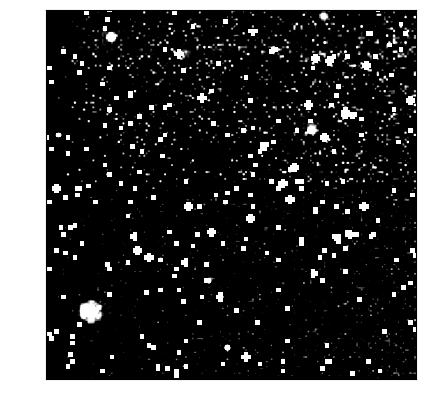

In [16]:
# Examine the First Image
ref_image = lvl2[0]
print(ref_image)
ref_fits = fits.open(ref_image)
ref_data = fits.open(ref_image)['SCI', 1].data
norm1 = simple_norm(ref_data, stretch='linear', min_cut=-1, max_cut=25)

plt.imshow(ref_data, origin='lower', norm=norm1, cmap='gray')
plt.gca().tick_params(labelcolor='none', axis='both', color='none')
plt.show()

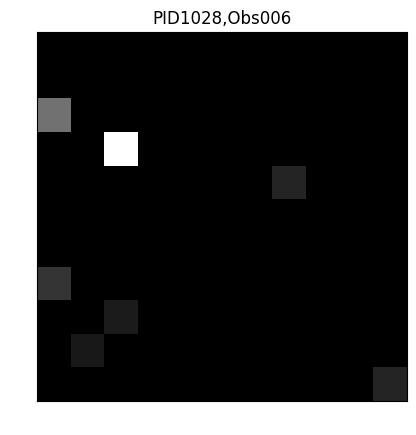

In [17]:
# Pick a blank part of the sky to calculate the upper limit
ref_y, ref_x = skycoord_to_pixel(source_location, wcs.WCS(ref_fits['SCI', 1], ref_fits))
ref_cutout = extract_array(ref_data, (11, 11), (ref_x, ref_y))
norm1 = simple_norm(ref_cutout, stretch='linear', min_cut=-1, max_cut=25)
plt.imshow(ref_cutout, origin='lower',
           norm=norm1, cmap='gray')
plt.title('PID1028,Obs006')
plt.gca().tick_params(labelcolor='none', axis='both', color='none')
plt.show()

Setting up sim to match jw01537024001_0310a_00001_nrcblong_cal.fits



MAST OPD query around UTC: 2022-09-08T10:35:01.135
                        MJD: 59830.44098535879

OPD immediately preceding the given datetime:
	URI:	 mast:JWST/product/O2022090801-NRCA3_FP1-1.fits
	Date (MJD):	 59829.7994
	Delta time:	 -0.6416 days

OPD immediately following the given datetime:
	URI:	 mast:JWST/product/R2022090902-NRCA3_FP1-1.fits
	Date (MJD):	 59831.6680
	Delta time:	 1.2270 days
User requested choosing OPD time closest in time to 2022-09-08T10:35:01.135, which is O2022090801-NRCA3_FP1-1.fits, delta time -0.642 days
Importing and format-converting OPD from ./webbpsf-data/webbpsf-data/MAST_JWST_WSS_OPDs/O2022090801-NRCA3_FP1-1.fits
Backing out SI WFE and OTE field dependence at the WF sensing field point



Configured simulation instrument for:
    Instrument: NIRCam
    Filter: F444W
    Detector: NRCB5
    Apername: NRCB5_SUB160
    Det. Pos.: (80, 80) in subarray
    Image plane mask: None
    Pupil plane mask: None
    

Running instrument: NIRCam, filter: F444W
  Running detector: NRCB5
    Position 1/1: (array(34.31117306), array(29.57819113)) pixels


    Position 1/1 centroid: (121.61475856280782, 121.19999121330285)

Running instrument: NIRCam, filter: F444W
  Running detector: NRCB5
    Position 1/1: (array(36.9401552), array(33.20685298)) pixels


    Position 1/1 centroid: (121.61503716739294, 121.19984303983951)

Running instrument: NIRCam, filter: F444W
  Running detector: NRCB5
    Position 1/1: (array(129.2776292), array(26.2678061)) pixels


    Position 1/1 centroid: (121.61508045221416, 121.20903132936235)

Running instrument: NIRCam, filter: F444W
  Running detector: NRCB5
    Position 1/1: (array(131.91827643), array(29.96922124)) pixels


    Position 1/1 centroid: (121.61523511808892, 121.20913828125003)

Running instrument: NIRCam, filter: F444W
  Running detector: NRCB5
    Position 1/1: (array(34.20512634), array(149.64538228)) pixels


    Position 1/1 centroid: (121.62019174224973, 121.19591314061994)

Running instrument: NIRCam, filter: F444W
  Running detector: NRCB5
    Position 1/1: (array(36.82602126), array(153.23305507)) pixels


    Position 1/1 centroid: (121.62012670336671, 121.19601217585985)

Running instrument: NIRCam, filter: F444W
  Running detector: NRCB5
    Position 1/1: (array(129.21386377), array(146.57107222)) pixels


    Position 1/1 centroid: (121.61893086748388, 121.20780845600966)

Running instrument: NIRCam, filter: F444W
  Running detector: NRCB5
    Position 1/1: (array(131.84050451), array(150.2086708)) pixels


    Position 1/1 centroid: (121.61884045072581, 121.20815277056805)


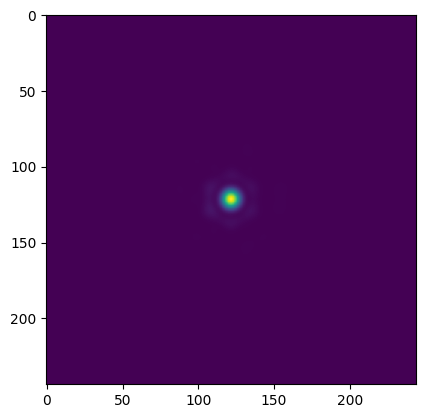

In [18]:
# Get PSF from WebbPSF
jwst_obs = space_phot.observation2(lvl2)
psfs = space_phot.get_jwst_psf(jwst_obs, source_location)
plt.imshow(psfs[0].data)
plt.show()

Finished PSF psf_photometry with median residuals of 96.26%


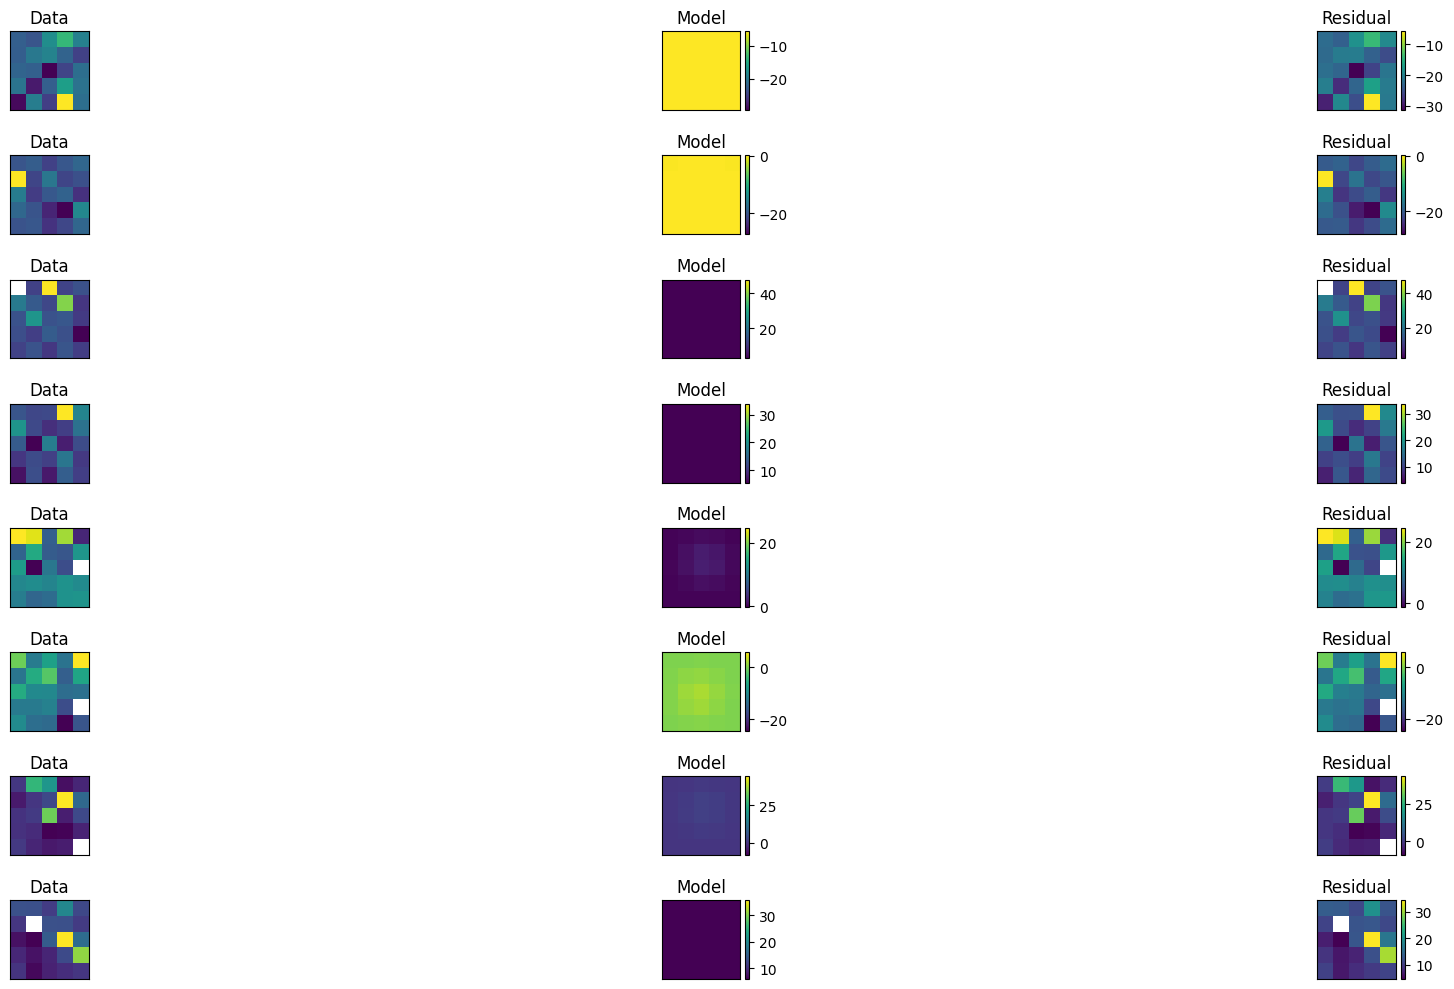

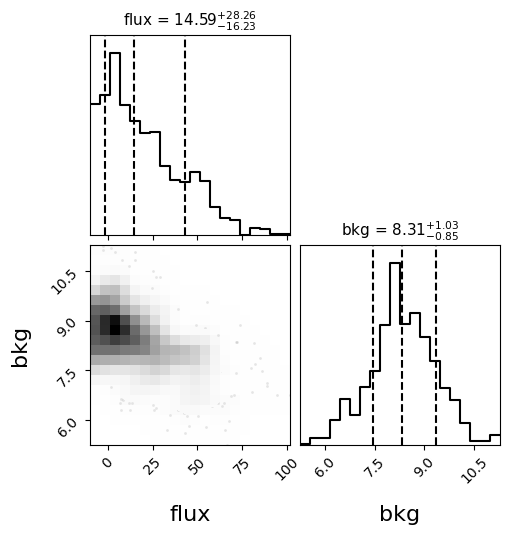

        ra        ...                     exp                    
----------------- ... -------------------------------------------
76.37757749999973 ... jw01537024001_0310a_00001_nrcblong_cal.fits
76.37757749999979 ... jw01537024001_0310a_00002_nrcblong_cal.fits
 76.3775774999995 ... jw01537024001_0310a_00003_nrcblong_cal.fits
76.37757749999939 ... jw01537024001_0310a_00004_nrcblong_cal.fits
76.37757749999984 ... jw01537024001_0310k_00001_nrcblong_cal.fits
76.37757750000006 ... jw01537024001_0310k_00002_nrcblong_cal.fits
76.37757749999902 ... jw01537024001_0310k_00003_nrcblong_cal.fits
 76.3775774999988 ... jw01537024001_0310k_00004_nrcblong_cal.fits


In [19]:
# Do PSF Photometry using space_phot (details of fitting are in documentation)
# https://st-phot.readthedocs.io/en/latest/examples/plot_a_psf.html#jwst-images
jwst_obs.psf_photometry(
    psfs,
    source_location,
    bounds={
        'flux': [-10, 1000],
        'bkg': [0, 50]
    },
    fit_width=5,
    fit_bkg=True,
    fit_centroid='fixed',
    fit_flux='single'
)

jwst_obs.plot_psf_fit()
plt.show()

jwst_obs.plot_psf_posterior(minweight=.0005)
plt.show()

print(jwst_obs.psf_result.phot_cal_table)

In [20]:
# Print Upper Limits
magupper_lvl2psf = jwst_obs.upper_limit(nsigma=5)
magupper_lvl2psf

array([21.36277454, 21.36277454, 21.36277454, 21.36277454, 21.36277453,
       21.36277453, 21.36277453, 21.36277453])

5.<font color='white'>-</font>Stellar Field (LMC)<a class="anchor" id="lmc"></a>
------------------

### 5.1<font color='white'>-</font>Multiple, Level2 Files<a class="anchor" id="lmc2"></a> ###

##### Now do the same thing for a larger group of stars and test for speed

In [21]:
# Level 3 Files: NIRCam Data PID 1476 (LMC)
lvl3 = 'jw01476-o001_t001_nircam_clear-f150w_i2d.fits'
lvl3

'jw01476-o001_t001_nircam_clear-f150w_i2d.fits'

In [22]:
hdl = fits.open(lvl3)
hdr = hdl[0].header
asnfile = hdr['ASNTABLE']
lvl2 = []
asn_data = load_asn(open(asnfile))
for member in asn_data['products'][0]['members']:
    lvl2.append(member['expname'])
    
lvl2 = [s for s in lvl2 if "nrca1" in s]
lvl2

['jw01476001007_02101_00001_nrca1_cal.fits',
 'jw01476001007_02101_00002_nrca1_cal.fits',
 'jw01476001007_02101_00003_nrca1_cal.fits',
 'jw01476001008_02101_00001_nrca1_cal.fits',
 'jw01476001008_02101_00002_nrca1_cal.fits',
 'jw01476001008_02101_00003_nrca1_cal.fits',
 'jw01476001008_02101_00004_nrca1_cal.fits',
 'jw01476001008_02101_00005_nrca1_cal.fits',
 'jw01476001008_02101_00006_nrca1_cal.fits']

In [23]:
# Find Stars in Level 3 File
# Get rough estimate of background (There are Better Ways to Do Background Subtraction)
bkgrms = MADStdBackgroundRMS()
mmm_bkg = MMMBackground()

im = fits.open(lvl3) 
w = wcs.WCS(im['SCI', 1])

std = bkgrms(im[1].data)
bkg = mmm_bkg(im[1].data)
data_bkgsub = im[1].data.copy()
data_bkgsub -= bkg        
sigma_psf = 1.636 # pixls for F770W
threshold = 5.

daofind = DAOStarFinder(threshold=threshold * std, fwhm=sigma_psf, exclude_border=True)
found_stars = daofind(data_bkgsub)

In [24]:
found_stars.pprint_all(max_lines=10)

  id       xcentroid          ycentroid          sharpness       roundness1       roundness2       npix sky        peak               flux                 mag         
------ ------------------ ------------------ ------------------ ----------- ---------------------- ---- --- ------------------ ------------------ ---------------------
     1 2313.3118063892607 7.4286735963825015 0.7464983603438533 -0.36265203 -0.0019793326763003637   25 0.0 42.873504638671875  10.74090576171875    -2.577602265496812
     2  2344.548909700025  9.123251339379284 0.7774905534228331  -0.5229935    -0.2107895798476327   25 0.0  6.612541198730469 1.8123018741607666   -0.6455763489187972
     3  2560.703618726967    9.0824757151874 0.7469957221325081 -0.20123221  -0.021288743090903697   25 0.0 22.579792022705078  5.954019069671631    -1.937025553203662
   ...                ...                ...                ...         ...                    ...  ... ...                ...                ...               

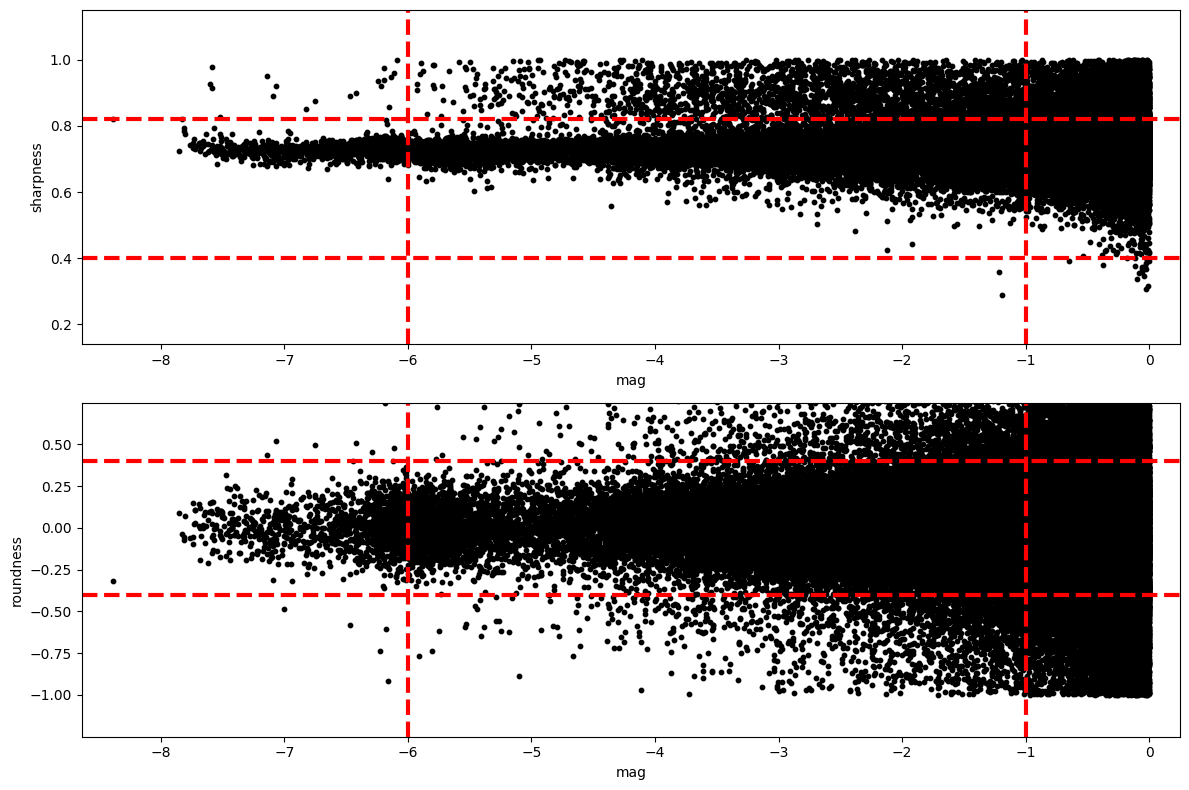

In [25]:
# Filter out only stars you want
plt.figure(figsize=(12, 8))
plt.clf()

ax1 = plt.subplot(2, 1, 1)

ax1.set_xlabel('mag')
ax1.set_ylabel('sharpness')

xlim0 = np.min(found_stars['mag']) - 0.25
xlim1 = np.max(found_stars['mag']) + 0.25
ylim0 = np.min(found_stars['sharpness']) - 0.15
ylim1 = np.max(found_stars['sharpness']) + 0.15

ax1.set_xlim(xlim0, xlim1)
ax1.set_ylim(ylim0, ylim1)

ax1.scatter(found_stars['mag'], found_stars['sharpness'], s=10, color='k')

sh_inf = 0.40
sh_sup = 0.82
lmag_lim = -1.0
umag_lim = -6.0

ax1.plot([xlim0, xlim1], [sh_sup, sh_sup], color='r', lw=3, ls='--')
ax1.plot([xlim0, xlim1], [sh_inf, sh_inf], color='r', lw=3, ls='--')
ax1.plot([lmag_lim, lmag_lim], [ylim0, ylim1], color='r', lw=3, ls='--')
ax1.plot([umag_lim, umag_lim], [ylim0, ylim1], color='r', lw=3, ls='--')

ax2 = plt.subplot(2, 1, 2)

ax2.set_xlabel('mag')
ax2.set_ylabel('roundness')

ylim0 = np.min(found_stars['roundness2']) - 0.25
ylim1 = np.max(found_stars['roundness2']) - 0.25

ax2.set_xlim(xlim0, xlim1)
ax2.set_ylim(ylim0, ylim1)

round_inf = -0.40
round_sup = 0.40

ax2.scatter(found_stars['mag'], found_stars['roundness2'], s=10, color='k')

ax2.plot([xlim0, xlim1], [round_sup, round_sup], color='r', lw=3, ls='--')
ax2.plot([xlim0, xlim1], [round_inf, round_inf], color='r', lw=3, ls='--')
ax2.plot([lmag_lim, lmag_lim], [ylim0, ylim1], color='r', lw=3, ls='--')
ax2.plot([umag_lim, umag_lim], [ylim0, ylim1], color='r', lw=3, ls='--')

plt.tight_layout()

In [26]:
mask = ((found_stars['mag'] < lmag_lim) & (found_stars['mag'] > umag_lim) & (found_stars['roundness2'] > round_inf)
        & (found_stars['roundness2'] < round_sup) & (found_stars['sharpness'] > sh_inf) 
        & (found_stars['sharpness'] < sh_sup) & (found_stars['xcentroid'] > 1940) & (found_stars['xcentroid'] < 2000)
        & (found_stars['ycentroid'] > 1890) & (found_stars['ycentroid'] < 1960))

found_stars_sel = found_stars[mask]

print('Number of stars found originally:', len(found_stars))
print('Number of stars in final selection:', len(found_stars_sel))

Number of stars found originally: 176103
Number of stars in final selection: 4


In [27]:
found_stars_sel

id,xcentroid,ycentroid,sharpness,roundness1,roundness2,npix,sky,peak,flux,mag
int64,float64,float64,float64,float32,float64,int64,float64,float64,float64,float64
54674,1946.0158736500082,1931.8259515714217,0.7395549721718143,-0.029228244,0.01395377781960557,25,0.0,60.01286315917969,15.238648414611816,-2.957366122872081
54788,1946.4225358003052,1935.8006427061637,0.7701400647554596,-0.49607956,0.18925854978211745,25,0.0,11.186172485351562,2.5969157218933105,-1.0361446390803886
55124,1997.6911211826132,1946.8426415139672,0.7590852075048468,0.00070237485,-0.04129163441477352,25,0.0,11.842582702636719,2.9808781147003174,-1.1858605462579643
55478,1958.742570307423,1959.0171574853969,0.715904958704722,-0.2507637,-0.03639336273266967,25,0.0,11.718515396118164,3.032212495803833,-1.2043990828694404


In [28]:
# Convert pixel to wcs coords
skycoords = w.pixel_to_world(found_stars_sel['xcentroid'], found_stars_sel['ycentroid'])
len(skycoords)

4

In [29]:
lvl2

['jw01476001007_02101_00001_nrca1_cal.fits',
 'jw01476001007_02101_00002_nrca1_cal.fits',
 'jw01476001007_02101_00003_nrca1_cal.fits',
 'jw01476001008_02101_00001_nrca1_cal.fits',
 'jw01476001008_02101_00002_nrca1_cal.fits',
 'jw01476001008_02101_00003_nrca1_cal.fits',
 'jw01476001008_02101_00004_nrca1_cal.fits',
 'jw01476001008_02101_00005_nrca1_cal.fits',
 'jw01476001008_02101_00006_nrca1_cal.fits']

In [30]:
file = lvl2[0]
dq = fits.open(file)['DQ', 1].data
dq[233, 340]

0

In [31]:
# Change all DQ flagged pixels to NANs
for file in lvl2:
    hdul = fits.open(file, mode='update')
    data = fits.open(file)['SCI', 1].data
    dq = fits.open(file)['DQ', 1].data
    data[dq == 262657] = np.nan
    data[dq == 262661] = np.nan
    hdul['SCI', 1].data = data
    hdul.flush()

In [32]:
# Create a grid for fast lookup using WebbPSF. The larger the grid, the better the photometric precision.
# Developer note. Would be great to have a fast/approximate look up table.
jwst_obs = space_phot.observation2(lvl2)
grid = space_phot.util.get_jwst_psf_grid(jwst_obs, num_psfs=4)

Setting up sim to match jw01476001007_02101_00001_nrca1_cal.fits


iterating query, tdelta=3.0

MAST OPD query around UTC: 2022-07-11T03:15:34.398
                        MJD: 59771.13581479167

OPD immediately preceding the given datetime:
	URI:	 mast:JWST/product/O2022071001-NRCA3_FP1-0.fits
	Date (MJD):	 59770.4830
	Delta time:	 -0.6529 days

OPD immediately following the given datetime:
	URI:	 mast:JWST/product/R2022071302-NRCA3_FP1-1.fits
	Date (MJD):	 59772.6632
	Delta time:	 1.5274 days
User requested choosing OPD time closest in time to 2022-07-11T03:15:34.398, which is O2022071001-NRCA3_FP1-0.fits, delta time -0.653 days


 [Done]


Importing and format-converting OPD from ./webbpsf-data/webbpsf-data/MAST_JWST_WSS_OPDs/O2022071001-NRCA3_FP1-0.fits
Backing out SI WFE and OTE field dependence at the WF sensing field point



Configured simulation instrument for:
    Instrument: NIRCam
    Filter: F150W
    Detector: NRCA1
    Apername: NRCA1_FULL
    Det. Pos.: (1024, 1024) 
    Image plane mask: None
    Pupil plane mask: None
    

Running instrument: NIRCam, filter: F150W
  Running detector: NRCA1
    Position 1/4: (0, 0) pixels


    Position 1/4 centroid: (201.21849572758828, 201.71204989920975)
    Position 2/4: (0, 2047) pixels


    Position 2/4 centroid: (201.47571369051525, 201.76630784134034)
    Position 3/4: (2047, 0) pixels


    Position 3/4 centroid: (201.25033871861956, 201.53013932680594)
    Position 4/4: (2047, 2047) pixels


    Position 4/4 centroid: (201.60882081144842, 201.4569860822112)
  Saving file: nircam_nrca1_f150w_fovp101_samp4_npsf4.fits


Starting 1.0  of 4 : <SkyCoord (ICRS): (ra, dec) in deg
    (80.36227052, -69.46233049)>


Finished PSF psf_photometry with median residuals of -0.49%


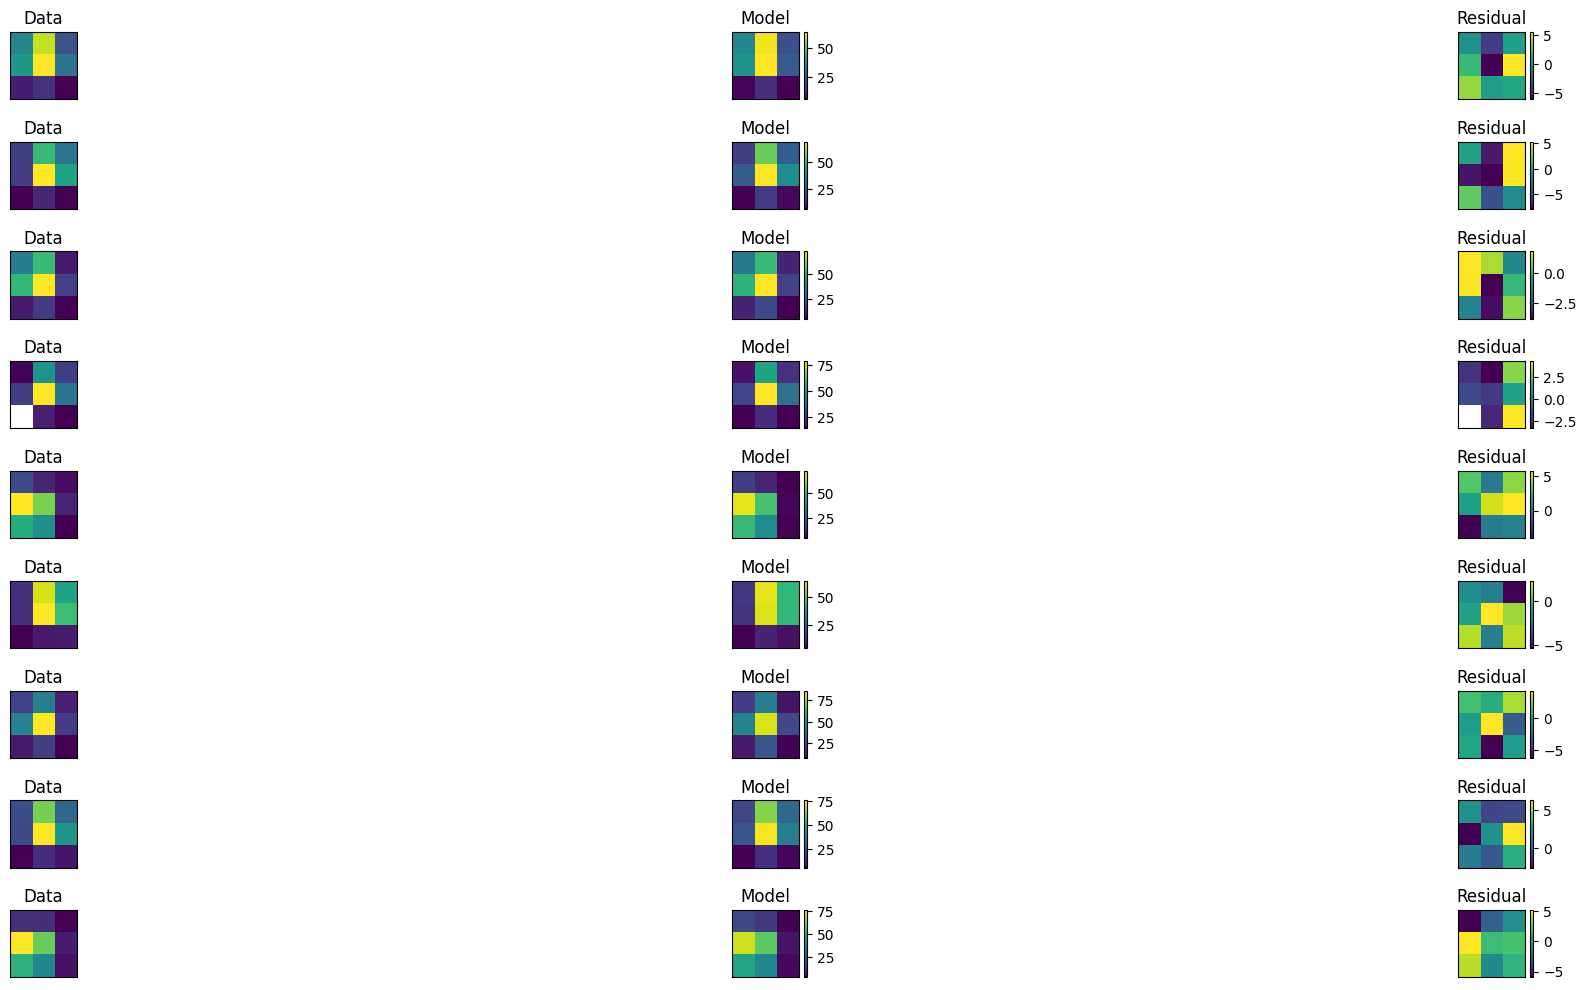

Elapsed Time for Photometry: 304.740332245
Starting 2.0  of 4 : <SkyCoord (ICRS): (ra, dec) in deg
    (80.36223231, -69.46236245)>


Finished PSF psf_photometry with median residuals of 6.92%


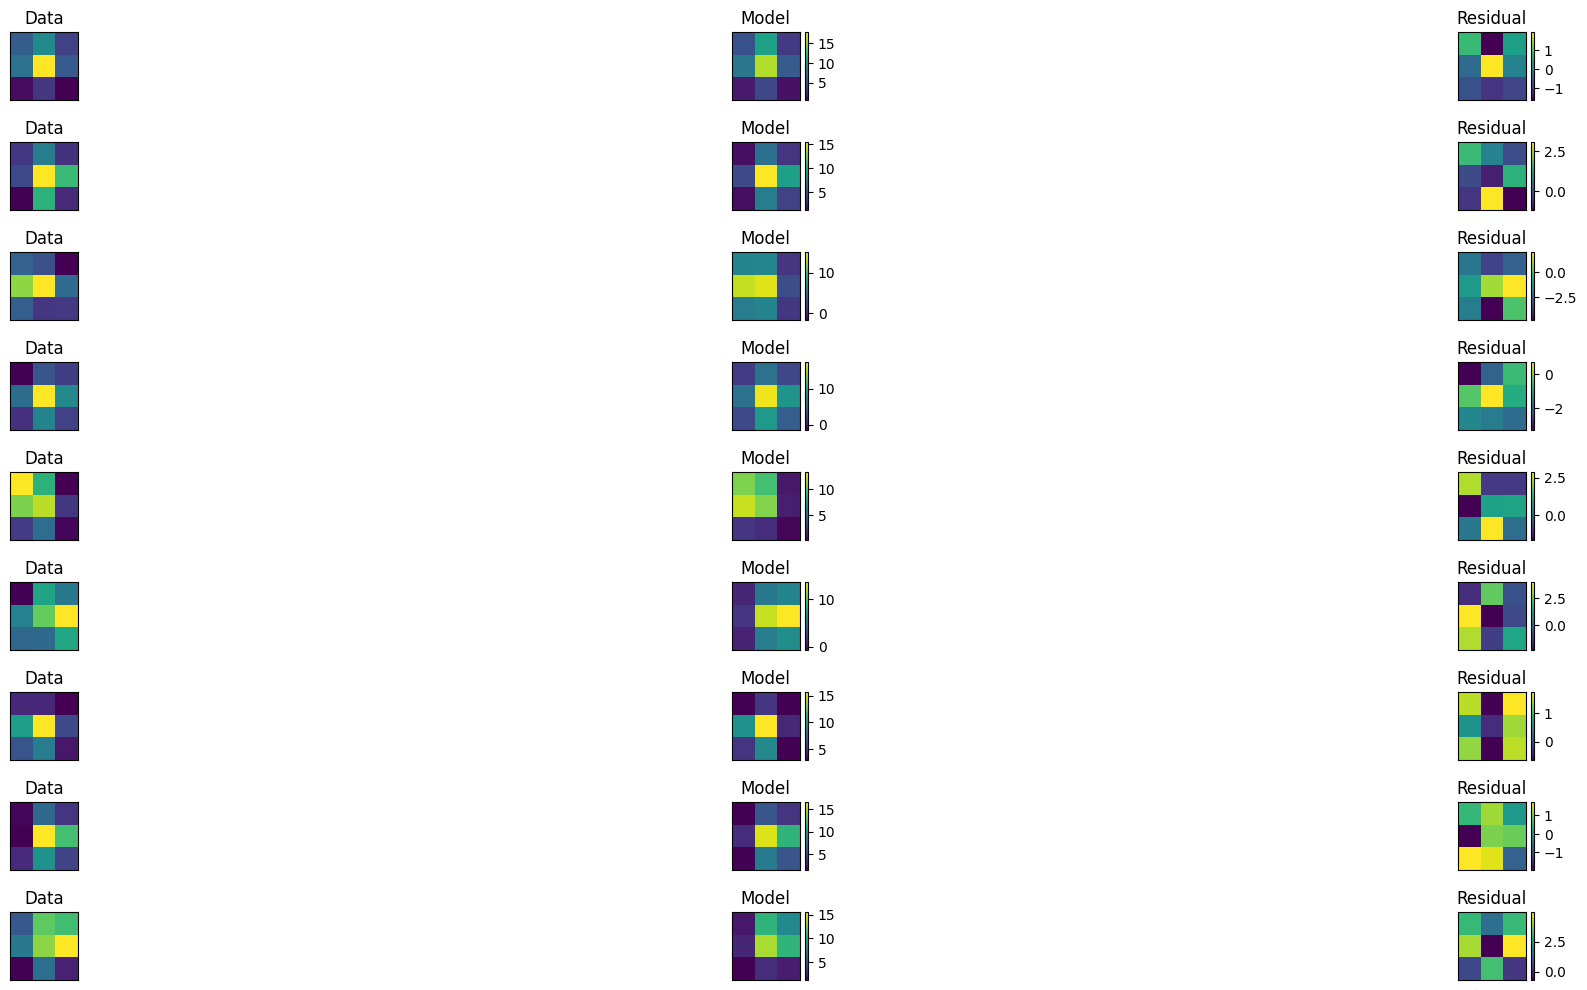

Elapsed Time for Photometry: 616.872915711
Starting 3.0  of 4 : <SkyCoord (ICRS): (ra, dec) in deg
    (80.36321461, -69.46265941)>


Finished PSF psf_photometry with median residuals of 4.21%


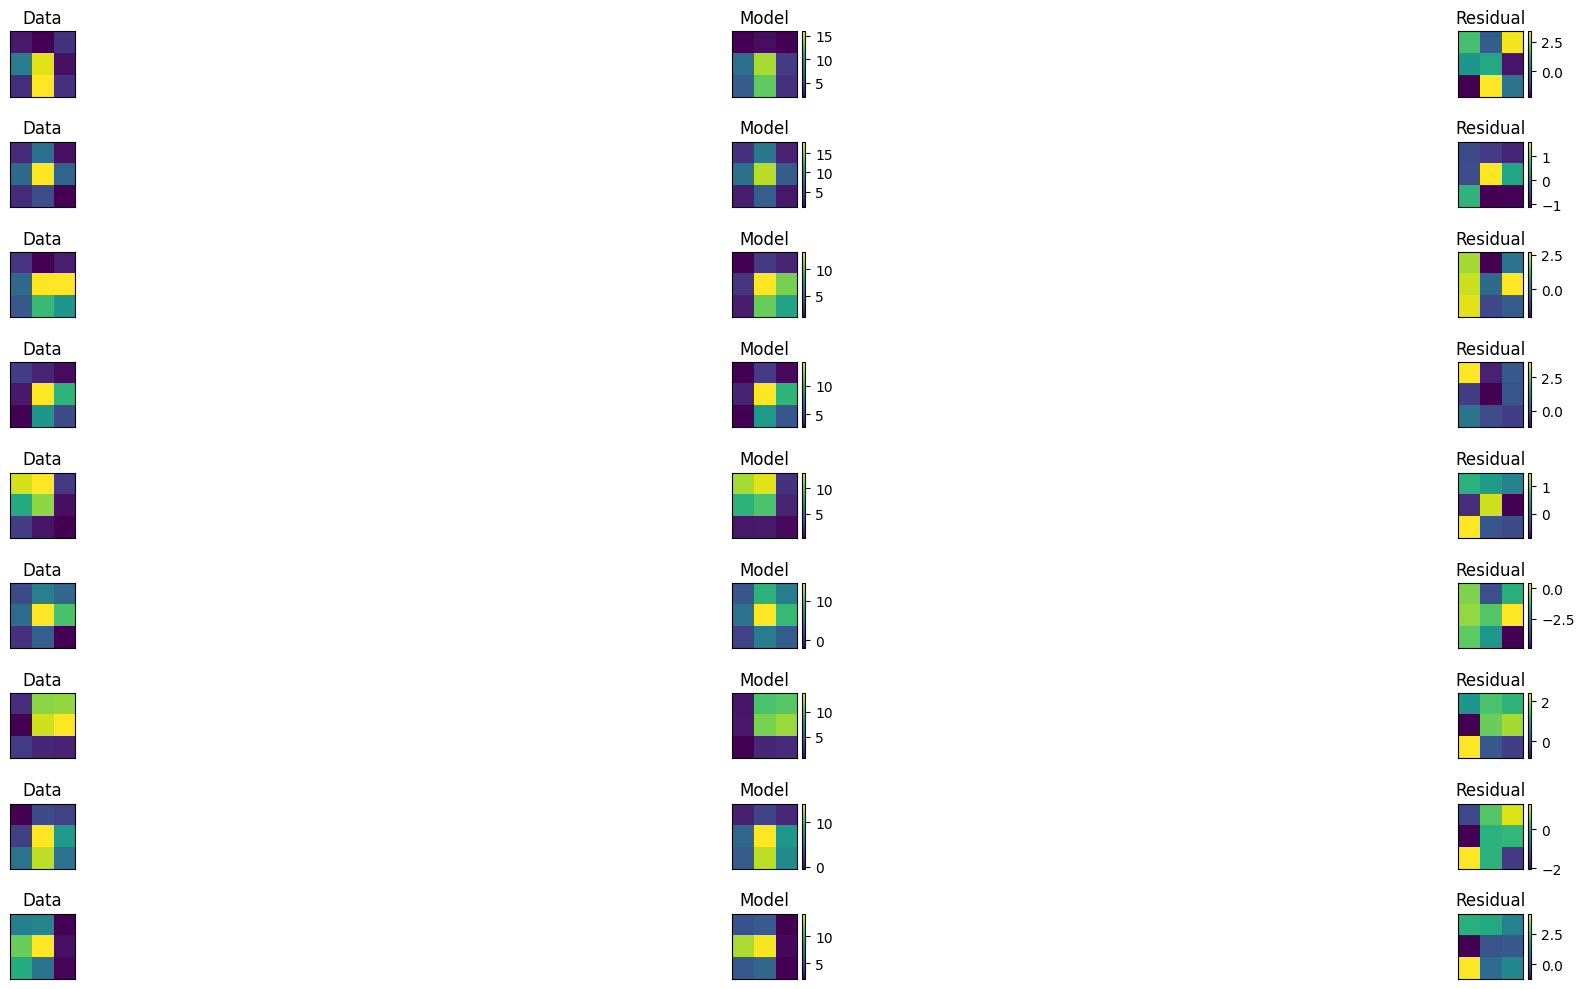

Elapsed Time for Photometry: 352.9469569359999
Starting 4.0  of 4 : <SkyCoord (ICRS): (ra, dec) in deg
    (80.36222499, -69.46259042)>


Finished PSF psf_photometry with median residuals of 4.54%


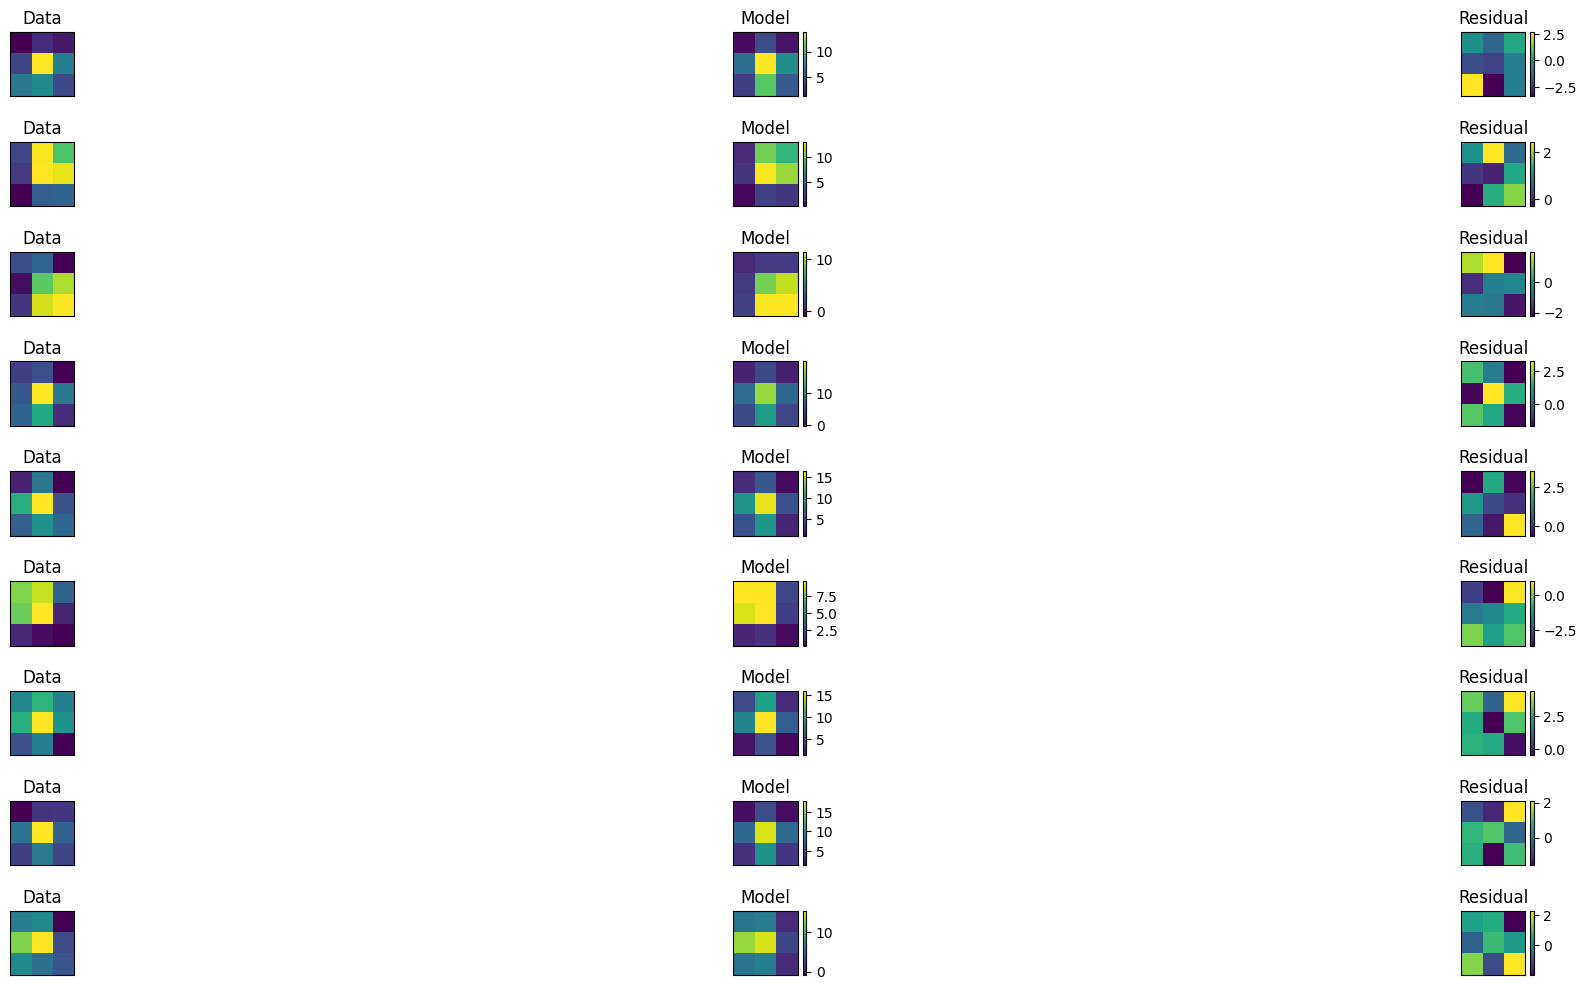

Elapsed Time for Photometry: 308.54818785399993


In [33]:
# Now Loop Through All Stars and Build Photometry Table
counter = 0.
badindex = []

jwst_obs = space_phot.observation2(lvl2)
for source_location in skycoords:
    tic = time.perf_counter()
    print('Starting', counter+1., ' of', len(skycoords), ':', source_location)
    psfs = space_phot.util.get_jwst_psf_from_grid(jwst_obs, source_location, grid)
    jwst_obs.psf_photometry(
        psfs,
        source_location,
        bounds={
            'flux': [-100, 1000],
            'centroid': [-2., 2.],
            'bkg': [0, 50]
        },
        fit_width=3,
        fit_bkg=False,
        fit_flux='single',
        maxiter=5000
    )
    
    jwst_obs.plot_psf_fit()
    plt.show()
    
    ra = jwst_obs.psf_result.phot_cal_table['ra'][0]
    dec = jwst_obs.psf_result.phot_cal_table['dec'][0]
    mag_arr = jwst_obs.psf_result.phot_cal_table['mag']
    magerr_arr = jwst_obs.psf_result.phot_cal_table['magerr']
    mag_lvl2psf = np.mean(mag_arr)
    magerr_lvl2psf = math.sqrt(sum(p**2 for p in magerr_arr))

    if counter == 0:
        df = pd.DataFrame(np.array([[ra, dec, mag_lvl2psf, magerr_lvl2psf]]), columns=['ra', 'dec', 'mag', 'magerr'])
    else:
        df = pd.concat([df, pd.DataFrame(np.array([[ra, dec, mag_lvl2psf, magerr_lvl2psf]]))], ignore_index=True)
    counter = counter + 1.
    
    toc = time.perf_counter()
    print("Elapsed Time for Photometry:", toc - tic)

### 5.2<font color='white'>-</font>Single, Level3 Mosaicked File<a class="anchor" id="lmc3"></a> ###

In [34]:
lvl3

'jw01476-o001_t001_nircam_clear-f150w_i2d.fits'

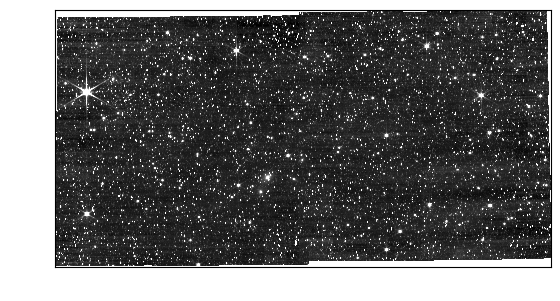

In [35]:
# Now do the same photometry on the Level 3 Data
ref_image = lvl3
ref_fits = fits.open(ref_image)
ref_data = fits.open(ref_image)['SCI', 1].data
norm1 = simple_norm(ref_data, stretch='linear', min_cut=-1, max_cut=10)

plt.imshow(ref_data, origin='lower',
           norm=norm1, cmap='gray')
plt.gca().tick_params(labelcolor='none', axis='both', color='none')
plt.show()

In [36]:
# Get PSF from WebbPSF and drizzle it to the source location
# Develop Note: Need Grid Capability for Level3 Data
jwst3_obs = space_phot.observation3(lvl3)

Starting 1.0  of 4 : <SkyCoord (ICRS): (ra, dec) in deg
    (80.36227052, -69.46233049)>
Setting up sim to match jw01476001007_02101_00001_nrca1_cal.fits


iterating query, tdelta=3.0

MAST OPD query around UTC: 2022-07-11T03:15:34.398
                        MJD: 59771.13581479167

OPD immediately preceding the given datetime:
	URI:	 mast:JWST/product/O2022071001-NRCA3_FP1-0.fits
	Date (MJD):	 59770.4830
	Delta time:	 -0.6529 days

OPD immediately following the given datetime:
	URI:	 mast:JWST/product/R2022071302-NRCA3_FP1-1.fits
	Date (MJD):	 59772.6632
	Delta time:	 1.5274 days
User requested choosing OPD time closest in time to 2022-07-11T03:15:34.398, which is O2022071001-NRCA3_FP1-0.fits, delta time -0.653 days
Importing and format-converting OPD from ./webbpsf-data/webbpsf-data/MAST_JWST_WSS_OPDs/O2022071001-NRCA3_FP1-0.fits


Backing out SI WFE and OTE field dependence at the WF sensing field point



Configured simulation instrument for:
    Instrument: NIRCam
    Filter: F150W
    Detector: NRCA1
    Apername: NRCA1_FULL
    Det. Pos.: (1024, 1024) 
    Image plane mask: None
    Pupil plane mask: None
    

Running instrument: NIRCam, filter: F150W
  Running detector: NRCA1
    Position 1/1: (array(1126.86543904), array(1146.52057269)) pixels


    Position 1/1 centroid: (201.55992421939706, 201.8843765866096)

Running instrument: NIRCam, filter: F150W
  Running detector: NRCA1
    Position 1/1: (array(1917.03200442), array(1934.79656079)) pixels


    Position 1/1 centroid: (201.61845202291718, 201.5163259100416)

Running instrument: NIRCam, filter: F150W
  Running detector: NRCA1
    Position 1/1: (array(349.60283338), array(1937.51518602)) pixels


    Position 1/1 centroid: (201.55050476133226, 201.74563632167653)

Running instrument: NIRCam, filter: F150W
  Running detector: NRCA1
    Position 1/1: (array(338.16789518), array(367.60077316)) pixels


    Position 1/1 centroid: (201.27212650501733, 201.7634997099658)

Running instrument: NIRCam, filter: F150W
  Running detector: NRCA1
    Position 1/1: (array(1908.53616612), array(348.45233452)) pixels


    Position 1/1 centroid: (201.3265143701293, 201.5680539278386)

Running instrument: NIRCam, filter: F150W
  Running detector: NRCA1
    Position 1/1: (array(1914.28873723), array(1141.72704463)) pixels


    Position 1/1 centroid: (201.5818020315682, 201.5933358752505)

Running instrument: NIRCam, filter: F150W
  Running detector: NRCA1
    Position 1/1: (array(1130.55147721), array(1935.69517957)) pixels


    Position 1/1 centroid: (201.60741360423833, 201.87669073712848)

Running instrument: NIRCam, filter: F150W
  Running detector: NRCA1
    Position 1/1: (array(345.03003817), array(1152.59085292)) pixels


    Position 1/1 centroid: (201.45732038441562, 201.75010376061186)

Running instrument: NIRCam, filter: F150W
  Running detector: NRCA1
    Position 1/1: (array(1120.52548599), array(357.26296042)) pixels


    Position 1/1 centroid: (201.32208323654777, 201.78858250433075)


2024-12-10 20:48:17,401 - stpipe.Image3Pipeline - INFO - Image3Pipeline instance created.


2024-12-10 20:48:17,402 - stpipe.Image3Pipeline.assign_mtwcs - INFO - AssignMTWcsStep instance created.


2024-12-10 20:48:17,404 - stpipe.Image3Pipeline.tweakreg - INFO - TweakRegStep instance created.


2024-12-10 20:48:17,406 - stpipe.Image3Pipeline.skymatch - INFO - SkyMatchStep instance created.


2024-12-10 20:48:17,408 - stpipe.Image3Pipeline.outlier_detection - INFO - OutlierDetectionStep instance created.


2024-12-10 20:48:17,409 - stpipe.Image3Pipeline.resample - INFO - ResampleStep instance created.


2024-12-10 20:48:17,410 - stpipe.Image3Pipeline.source_catalog - INFO - SourceCatalogStep instance created.


2024-12-10 20:48:17,549 - stpipe.Image3Pipeline - INFO - Step Image3Pipeline running with args ('./temp_psf_dir/cal_data_asn.json',).


2024-12-10 20:48:17,562 - stpipe.Image3Pipeline - INFO - Step Image3Pipeline parameters are:
  pre_hooks: []
  post_hooks: []
  output_file: None
  output_dir: ./temp_psf_dir
  output_ext: .fits
  output_use_model: False
  output_use_index: True
  save_results: True
  skip: False
  suffix: None
  search_output_file: True
  input_dir: ''
  in_memory: True
  steps:
    assign_mtwcs:
      pre_hooks: []
      post_hooks: []
      output_file: None
      output_dir: None
      output_ext: .fits
      output_use_model: True
      output_use_index: True
      save_results: False
      skip: False
      suffix: assign_mtwcs
      search_output_file: True
      input_dir: ''
    tweakreg:
      pre_hooks: []
      post_hooks: []
      output_file: None
      output_dir: None
      output_ext: .fits
      output_use_model: True
      output_use_index: True
      save_results: False
      skip: True
      suffix: None
      search_output_file: True
      input_dir: ''
      save_catalogs: False


2024-12-10 20:48:17,562 - stpipe.Image3Pipeline - INFO - Starting calwebb_image3 ...


2024-12-10 20:48:19,211 - stpipe.Image3Pipeline.tweakreg - INFO - Step tweakreg running with args (<jwst.datamodels.library.ModelLibrary object at 0x7f3eba9a6050>,).


2024-12-10 20:48:19,211 - stpipe.Image3Pipeline.tweakreg - INFO - Step skipped.


2024-12-10 20:48:21,756 - stpipe.Image3Pipeline.skymatch - INFO - Step skymatch running with args (<jwst.datamodels.library.ModelLibrary object at 0x7f3eba9a6050>,).


2024-12-10 20:48:21,756 - stpipe.Image3Pipeline.skymatch - INFO - Step skipped.


2024-12-10 20:48:21,911 - stpipe.Image3Pipeline.outlier_detection - INFO - Step outlier_detection running with args (<jwst.datamodels.library.ModelLibrary object at 0x7f3eba9a6050>,).


2024-12-10 20:48:21,912 - stpipe.Image3Pipeline.outlier_detection - INFO - Step skipped.


2024-12-10 20:48:22,061 - stpipe.Image3Pipeline.resample - INFO - Step resample running with args (<jwst.datamodels.library.ModelLibrary object at 0x7f3eba9a6050>,).


2024-12-10 20:48:22,063 - stpipe.Image3Pipeline.resample - WARNING - Mismatched data shapes; skipping invalid data updates for extension 'err'


2024-12-10 20:48:22,063 - stpipe.Image3Pipeline.resample - WARNING - Mismatched data shapes; skipping invalid data updates for extension 'var_rnoise'


2024-12-10 20:48:22,064 - stpipe.Image3Pipeline.resample - WARNING - Mismatched data shapes; skipping invalid data updates for extension 'var_poisson'


2024-12-10 20:48:22,064 - stpipe.Image3Pipeline.resample - WARNING - Mismatched data shapes; skipping invalid data updates for extension 'var_flat'


2024-12-10 20:48:22,071 - stpipe.Image3Pipeline.resample - WARNING - Mismatched data shapes; skipping invalid data updates for extension 'err'


2024-12-10 20:48:22,072 - stpipe.Image3Pipeline.resample - WARNING - Mismatched data shapes; skipping invalid data updates for extension 'var_rnoise'


2024-12-10 20:48:22,072 - stpipe.Image3Pipeline.resample - WARNING - Mismatched data shapes; skipping invalid data updates for extension 'var_poisson'


2024-12-10 20:48:22,073 - stpipe.Image3Pipeline.resample - WARNING - Mismatched data shapes; skipping invalid data updates for extension 'var_flat'


2024-12-10 20:48:22,077 - stpipe.Image3Pipeline.resample - WARNING - Mismatched data shapes; skipping invalid data updates for extension 'err'


2024-12-10 20:48:22,077 - stpipe.Image3Pipeline.resample - WARNING - Mismatched data shapes; skipping invalid data updates for extension 'var_rnoise'


2024-12-10 20:48:22,078 - stpipe.Image3Pipeline.resample - WARNING - Mismatched data shapes; skipping invalid data updates for extension 'var_poisson'


2024-12-10 20:48:22,078 - stpipe.Image3Pipeline.resample - WARNING - Mismatched data shapes; skipping invalid data updates for extension 'var_flat'


2024-12-10 20:48:22,082 - stpipe.Image3Pipeline.resample - WARNING - Mismatched data shapes; skipping invalid data updates for extension 'err'


2024-12-10 20:48:22,083 - stpipe.Image3Pipeline.resample - WARNING - Mismatched data shapes; skipping invalid data updates for extension 'var_rnoise'


2024-12-10 20:48:22,083 - stpipe.Image3Pipeline.resample - WARNING - Mismatched data shapes; skipping invalid data updates for extension 'var_poisson'


2024-12-10 20:48:22,084 - stpipe.Image3Pipeline.resample - WARNING - Mismatched data shapes; skipping invalid data updates for extension 'var_flat'


2024-12-10 20:48:22,088 - stpipe.Image3Pipeline.resample - WARNING - Mismatched data shapes; skipping invalid data updates for extension 'err'


2024-12-10 20:48:22,088 - stpipe.Image3Pipeline.resample - WARNING - Mismatched data shapes; skipping invalid data updates for extension 'var_rnoise'


2024-12-10 20:48:22,089 - stpipe.Image3Pipeline.resample - WARNING - Mismatched data shapes; skipping invalid data updates for extension 'var_poisson'


2024-12-10 20:48:22,089 - stpipe.Image3Pipeline.resample - WARNING - Mismatched data shapes; skipping invalid data updates for extension 'var_flat'


2024-12-10 20:48:22,093 - stpipe.Image3Pipeline.resample - WARNING - Mismatched data shapes; skipping invalid data updates for extension 'err'


2024-12-10 20:48:22,094 - stpipe.Image3Pipeline.resample - WARNING - Mismatched data shapes; skipping invalid data updates for extension 'var_rnoise'


2024-12-10 20:48:22,094 - stpipe.Image3Pipeline.resample - WARNING - Mismatched data shapes; skipping invalid data updates for extension 'var_poisson'


2024-12-10 20:48:22,095 - stpipe.Image3Pipeline.resample - WARNING - Mismatched data shapes; skipping invalid data updates for extension 'var_flat'


2024-12-10 20:48:22,099 - stpipe.Image3Pipeline.resample - WARNING - Mismatched data shapes; skipping invalid data updates for extension 'err'


2024-12-10 20:48:22,099 - stpipe.Image3Pipeline.resample - WARNING - Mismatched data shapes; skipping invalid data updates for extension 'var_rnoise'


2024-12-10 20:48:22,100 - stpipe.Image3Pipeline.resample - WARNING - Mismatched data shapes; skipping invalid data updates for extension 'var_poisson'


2024-12-10 20:48:22,100 - stpipe.Image3Pipeline.resample - WARNING - Mismatched data shapes; skipping invalid data updates for extension 'var_flat'


2024-12-10 20:48:22,104 - stpipe.Image3Pipeline.resample - WARNING - Mismatched data shapes; skipping invalid data updates for extension 'err'


2024-12-10 20:48:22,105 - stpipe.Image3Pipeline.resample - WARNING - Mismatched data shapes; skipping invalid data updates for extension 'var_rnoise'


2024-12-10 20:48:22,105 - stpipe.Image3Pipeline.resample - WARNING - Mismatched data shapes; skipping invalid data updates for extension 'var_poisson'


2024-12-10 20:48:22,105 - stpipe.Image3Pipeline.resample - WARNING - Mismatched data shapes; skipping invalid data updates for extension 'var_flat'


2024-12-10 20:48:22,110 - stpipe.Image3Pipeline.resample - WARNING - Mismatched data shapes; skipping invalid data updates for extension 'err'


2024-12-10 20:48:22,110 - stpipe.Image3Pipeline.resample - WARNING - Mismatched data shapes; skipping invalid data updates for extension 'var_rnoise'


2024-12-10 20:48:22,110 - stpipe.Image3Pipeline.resample - WARNING - Mismatched data shapes; skipping invalid data updates for extension 'var_poisson'


2024-12-10 20:48:22,111 - stpipe.Image3Pipeline.resample - WARNING - Mismatched data shapes; skipping invalid data updates for extension 'var_flat'


2024-12-10 20:48:22,114 - stpipe.Image3Pipeline.resample - INFO - Driz parameter kernel: square


2024-12-10 20:48:22,114 - stpipe.Image3Pipeline.resample - INFO - Driz parameter pixfrac: 1.0


2024-12-10 20:48:22,115 - stpipe.Image3Pipeline.resample - INFO - Driz parameter fillval: NAN


2024-12-10 20:48:22,116 - stpipe.Image3Pipeline.resample - INFO - Driz parameter weight_type: ivm


2024-12-10 20:48:22,116 - stpipe.Image3Pipeline.resample - INFO - Output pixel scale: 0.03122691827458939 arcsec.


2024-12-10 20:48:22,363 - stpipe.Image3Pipeline.resample - INFO - Resampling science data


2024-12-10 20:48:25,014 - stpipe.Image3Pipeline.resample - INFO - Drizzling (2048, 2048) --> (3644, 3643)


2024-12-10 20:48:27,936 - stpipe.Image3Pipeline.resample - INFO - Drizzling (2048, 2048) --> (3644, 3643)


2024-12-10 20:48:30,825 - stpipe.Image3Pipeline.resample - INFO - Drizzling (2048, 2048) --> (3644, 3643)


2024-12-10 20:48:33,721 - stpipe.Image3Pipeline.resample - INFO - Drizzling (2048, 2048) --> (3644, 3643)


2024-12-10 20:48:36,622 - stpipe.Image3Pipeline.resample - INFO - Drizzling (2048, 2048) --> (3644, 3643)


2024-12-10 20:48:39,510 - stpipe.Image3Pipeline.resample - INFO - Drizzling (2048, 2048) --> (3644, 3643)


2024-12-10 20:48:42,442 - stpipe.Image3Pipeline.resample - INFO - Drizzling (2048, 2048) --> (3644, 3643)


2024-12-10 20:48:45,359 - stpipe.Image3Pipeline.resample - INFO - Drizzling (2048, 2048) --> (3644, 3643)


2024-12-10 20:48:48,256 - stpipe.Image3Pipeline.resample - INFO - Drizzling (2048, 2048) --> (3644, 3643)


2024-12-10 20:48:49,489 - stpipe.Image3Pipeline.resample - INFO - Resampling variance components


2024-12-10 20:48:49,525 - stpipe.Image3Pipeline.resample - WARNING - Data shape mismatch for 'var_rnoise' for model 'jw01476001007_02101_00001_nrca1_cal.fits'. Skipping ...


2024-12-10 20:48:49,537 - stpipe.Image3Pipeline.resample - WARNING - Data shape mismatch for 'var_poisson' for model 'jw01476001007_02101_00001_nrca1_cal.fits'. Skipping ...


2024-12-10 20:48:49,538 - stpipe.Image3Pipeline.resample - WARNING - Data shape mismatch for 'var_flat' for model 'jw01476001007_02101_00001_nrca1_cal.fits'. Skipping ...


2024-12-10 20:48:49,539 - stpipe.Image3Pipeline.resample - WARNING - Data shape mismatch for 'var_rnoise' for model 'jw01476001007_02101_00002_nrca1_cal.fits'. Skipping ...


2024-12-10 20:48:49,551 - stpipe.Image3Pipeline.resample - WARNING - Data shape mismatch for 'var_poisson' for model 'jw01476001007_02101_00002_nrca1_cal.fits'. Skipping ...


2024-12-10 20:48:49,551 - stpipe.Image3Pipeline.resample - WARNING - Data shape mismatch for 'var_flat' for model 'jw01476001007_02101_00002_nrca1_cal.fits'. Skipping ...


2024-12-10 20:48:49,552 - stpipe.Image3Pipeline.resample - WARNING - Data shape mismatch for 'var_rnoise' for model 'jw01476001007_02101_00003_nrca1_cal.fits'. Skipping ...


2024-12-10 20:48:49,564 - stpipe.Image3Pipeline.resample - WARNING - Data shape mismatch for 'var_poisson' for model 'jw01476001007_02101_00003_nrca1_cal.fits'. Skipping ...


2024-12-10 20:48:49,564 - stpipe.Image3Pipeline.resample - WARNING - Data shape mismatch for 'var_flat' for model 'jw01476001007_02101_00003_nrca1_cal.fits'. Skipping ...


2024-12-10 20:48:49,565 - stpipe.Image3Pipeline.resample - WARNING - Data shape mismatch for 'var_rnoise' for model 'jw01476001008_02101_00001_nrca1_cal.fits'. Skipping ...


2024-12-10 20:48:49,577 - stpipe.Image3Pipeline.resample - WARNING - Data shape mismatch for 'var_poisson' for model 'jw01476001008_02101_00001_nrca1_cal.fits'. Skipping ...


2024-12-10 20:48:49,578 - stpipe.Image3Pipeline.resample - WARNING - Data shape mismatch for 'var_flat' for model 'jw01476001008_02101_00001_nrca1_cal.fits'. Skipping ...


2024-12-10 20:48:49,578 - stpipe.Image3Pipeline.resample - WARNING - Data shape mismatch for 'var_rnoise' for model 'jw01476001008_02101_00002_nrca1_cal.fits'. Skipping ...


2024-12-10 20:48:49,590 - stpipe.Image3Pipeline.resample - WARNING - Data shape mismatch for 'var_poisson' for model 'jw01476001008_02101_00002_nrca1_cal.fits'. Skipping ...


2024-12-10 20:48:49,591 - stpipe.Image3Pipeline.resample - WARNING - Data shape mismatch for 'var_flat' for model 'jw01476001008_02101_00002_nrca1_cal.fits'. Skipping ...


2024-12-10 20:48:49,591 - stpipe.Image3Pipeline.resample - WARNING - Data shape mismatch for 'var_rnoise' for model 'jw01476001008_02101_00003_nrca1_cal.fits'. Skipping ...


2024-12-10 20:48:49,603 - stpipe.Image3Pipeline.resample - WARNING - Data shape mismatch for 'var_poisson' for model 'jw01476001008_02101_00003_nrca1_cal.fits'. Skipping ...


2024-12-10 20:48:49,604 - stpipe.Image3Pipeline.resample - WARNING - Data shape mismatch for 'var_flat' for model 'jw01476001008_02101_00003_nrca1_cal.fits'. Skipping ...


2024-12-10 20:48:49,605 - stpipe.Image3Pipeline.resample - WARNING - Data shape mismatch for 'var_rnoise' for model 'jw01476001008_02101_00004_nrca1_cal.fits'. Skipping ...


2024-12-10 20:48:49,617 - stpipe.Image3Pipeline.resample - WARNING - Data shape mismatch for 'var_poisson' for model 'jw01476001008_02101_00004_nrca1_cal.fits'. Skipping ...


2024-12-10 20:48:49,617 - stpipe.Image3Pipeline.resample - WARNING - Data shape mismatch for 'var_flat' for model 'jw01476001008_02101_00004_nrca1_cal.fits'. Skipping ...


2024-12-10 20:48:49,618 - stpipe.Image3Pipeline.resample - WARNING - Data shape mismatch for 'var_rnoise' for model 'jw01476001008_02101_00005_nrca1_cal.fits'. Skipping ...


2024-12-10 20:48:49,630 - stpipe.Image3Pipeline.resample - WARNING - Data shape mismatch for 'var_poisson' for model 'jw01476001008_02101_00005_nrca1_cal.fits'. Skipping ...


2024-12-10 20:48:49,630 - stpipe.Image3Pipeline.resample - WARNING - Data shape mismatch for 'var_flat' for model 'jw01476001008_02101_00005_nrca1_cal.fits'. Skipping ...


2024-12-10 20:48:49,631 - stpipe.Image3Pipeline.resample - WARNING - Data shape mismatch for 'var_rnoise' for model 'jw01476001008_02101_00006_nrca1_cal.fits'. Skipping ...


2024-12-10 20:48:49,643 - stpipe.Image3Pipeline.resample - WARNING - Data shape mismatch for 'var_poisson' for model 'jw01476001008_02101_00006_nrca1_cal.fits'. Skipping ...


2024-12-10 20:48:49,644 - stpipe.Image3Pipeline.resample - WARNING - Data shape mismatch for 'var_flat' for model 'jw01476001008_02101_00006_nrca1_cal.fits'. Skipping ...


2024-12-10 20:48:49,838 - stpipe.Image3Pipeline.resample - INFO - Update S_REGION to POLYGON ICRS  80.342792691 -69.439581834 80.299723380 -69.467341703 80.378888523 -69.482445324 80.421885728 -69.454665929


2024-12-10 20:48:50,623 - stpipe.Image3Pipeline.resample - INFO - Saved model in ./temp_psf_dir/temp_psf_cals_i2d.fits


2024-12-10 20:48:50,624 - stpipe.Image3Pipeline.resample - INFO - Step resample done


2024-12-10 20:48:50,842 - stpipe.Image3Pipeline.source_catalog - INFO - Step source_catalog running with args (<ImageModel(3644, 3643) from temp_psf_cals_i2d.fits>,).


2024-12-10 20:48:50,842 - stpipe.Image3Pipeline.source_catalog - INFO - Step skipped.


2024-12-10 20:48:50,850 - stpipe.Image3Pipeline - INFO - Step Image3Pipeline done


2024-12-10 20:48:50,850 - stpipe - INFO - Results used jwst version: 1.16.1


Finished PSF psf_photometry with median residuals of 0.65%


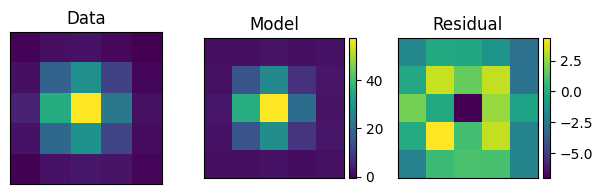

Elapsed Time for Photometry: 89.82445816900008
Starting 2.0  of 4 : <SkyCoord (ICRS): (ra, dec) in deg
    (80.36223231, -69.46236245)>
Setting up sim to match jw01476001007_02101_00001_nrca1_cal.fits


iterating query, tdelta=3.0

MAST OPD query around UTC: 2022-07-11T03:15:34.398
                        MJD: 59771.13581479167

OPD immediately preceding the given datetime:
	URI:	 mast:JWST/product/O2022071001-NRCA3_FP1-0.fits
	Date (MJD):	 59770.4830
	Delta time:	 -0.6529 days

OPD immediately following the given datetime:
	URI:	 mast:JWST/product/R2022071302-NRCA3_FP1-1.fits
	Date (MJD):	 59772.6632
	Delta time:	 1.5274 days
User requested choosing OPD time closest in time to 2022-07-11T03:15:34.398, which is O2022071001-NRCA3_FP1-0.fits, delta time -0.653 days
Importing and format-converting OPD from ./webbpsf-data/webbpsf-data/MAST_JWST_WSS_OPDs/O2022071001-NRCA3_FP1-0.fits


Backing out SI WFE and OTE field dependence at the WF sensing field point



Configured simulation instrument for:
    Instrument: NIRCam
    Filter: F150W
    Detector: NRCA1
    Apername: NRCA1_FULL
    Det. Pos.: (1024, 1024) 
    Image plane mask: None
    Pupil plane mask: None
    

Running instrument: NIRCam, filter: F150W
  Running detector: NRCA1
    Position 1/1: (array(1130.83133668), array(1146.92815302)) pixels


    Position 1/1 centroid: (201.56015943220993, 201.88410402044425)

Running instrument: NIRCam, filter: F150W
  Running detector: NRCA1
    Position 1/1: (array(1921.01738484), array(1935.23196474)) pixels


    Position 1/1 centroid: (201.61849143078894, 201.51430355677192)

Running instrument: NIRCam, filter: F150W
  Running detector: NRCA1
    Position 1/1: (array(353.53276979), array(1937.93602556)) pixels


    Position 1/1 centroid: (201.55111488663647, 201.74517776845153)

Running instrument: NIRCam, filter: F150W
  Running detector: NRCA1
    Position 1/1: (array(342.10711399), array(367.97668346)) pixels


    Position 1/1 centroid: (201.2720012017965, 201.761363868563)

Running instrument: NIRCam, filter: F150W
  Running detector: NRCA1
    Position 1/1: (array(1912.53299126), array(348.84905306)) pixels


    Position 1/1 centroid: (201.3266410104566, 201.56687745699688)

Running instrument: NIRCam, filter: F150W
  Running detector: NRCA1
    Position 1/1: (array(1918.28071506), array(1142.14323121)) pixels


    Position 1/1 centroid: (201.5821929306246, 201.59139093344382)

Running instrument: NIRCam, filter: F150W
  Running detector: NRCA1
    Position 1/1: (array(1134.51135984), array(1936.12325951)) pixels


    Position 1/1 centroid: (201.606980301233, 201.8760879439699)

Running instrument: NIRCam, filter: F150W
  Running detector: NRCA1
    Position 1/1: (array(348.9656061), array(1152.9898266)) pixels


    Position 1/1 centroid: (201.45732845086877, 201.7493383330231)

Running instrument: NIRCam, filter: F150W
  Running detector: NRCA1
    Position 1/1: (array(1124.4955227), array(357.64935008)) pixels


    Position 1/1 centroid: (201.32222841895336, 201.788521341307)


2024-12-10 20:49:46,485 - stpipe.Image3Pipeline - INFO - Image3Pipeline instance created.


2024-12-10 20:49:46,486 - stpipe.Image3Pipeline.assign_mtwcs - INFO - AssignMTWcsStep instance created.


2024-12-10 20:49:46,489 - stpipe.Image3Pipeline.tweakreg - INFO - TweakRegStep instance created.


2024-12-10 20:49:46,490 - stpipe.Image3Pipeline.skymatch - INFO - SkyMatchStep instance created.


2024-12-10 20:49:46,492 - stpipe.Image3Pipeline.outlier_detection - INFO - OutlierDetectionStep instance created.


2024-12-10 20:49:46,493 - stpipe.Image3Pipeline.resample - INFO - ResampleStep instance created.


2024-12-10 20:49:46,495 - stpipe.Image3Pipeline.source_catalog - INFO - SourceCatalogStep instance created.


2024-12-10 20:49:46,651 - stpipe.Image3Pipeline - INFO - Step Image3Pipeline running with args ('./temp_psf_dir/cal_data_asn.json',).


2024-12-10 20:49:46,665 - stpipe.Image3Pipeline - INFO - Step Image3Pipeline parameters are:
  pre_hooks: []
  post_hooks: []
  output_file: None
  output_dir: ./temp_psf_dir
  output_ext: .fits
  output_use_model: False
  output_use_index: True
  save_results: True
  skip: False
  suffix: None
  search_output_file: True
  input_dir: ''
  in_memory: True
  steps:
    assign_mtwcs:
      pre_hooks: []
      post_hooks: []
      output_file: None
      output_dir: None
      output_ext: .fits
      output_use_model: True
      output_use_index: True
      save_results: False
      skip: False
      suffix: assign_mtwcs
      search_output_file: True
      input_dir: ''
    tweakreg:
      pre_hooks: []
      post_hooks: []
      output_file: None
      output_dir: None
      output_ext: .fits
      output_use_model: True
      output_use_index: True
      save_results: False
      skip: True
      suffix: None
      search_output_file: True
      input_dir: ''
      save_catalogs: False


2024-12-10 20:49:46,666 - stpipe.Image3Pipeline - INFO - Starting calwebb_image3 ...


2024-12-10 20:49:47,176 - stpipe.Image3Pipeline.tweakreg - INFO - Step tweakreg running with args (<jwst.datamodels.library.ModelLibrary object at 0x7f3e4a5d6a90>,).


2024-12-10 20:49:47,177 - stpipe.Image3Pipeline.tweakreg - INFO - Step skipped.


2024-12-10 20:49:49,186 - stpipe.Image3Pipeline.skymatch - INFO - Step skymatch running with args (<jwst.datamodels.library.ModelLibrary object at 0x7f3e4a5d6a90>,).


2024-12-10 20:49:49,187 - stpipe.Image3Pipeline.skymatch - INFO - Step skipped.


2024-12-10 20:49:49,347 - stpipe.Image3Pipeline.outlier_detection - INFO - Step outlier_detection running with args (<jwst.datamodels.library.ModelLibrary object at 0x7f3e4a5d6a90>,).


2024-12-10 20:49:49,348 - stpipe.Image3Pipeline.outlier_detection - INFO - Step skipped.


2024-12-10 20:49:49,515 - stpipe.Image3Pipeline.resample - INFO - Step resample running with args (<jwst.datamodels.library.ModelLibrary object at 0x7f3e4a5d6a90>,).


2024-12-10 20:49:49,517 - stpipe.Image3Pipeline.resample - WARNING - Mismatched data shapes; skipping invalid data updates for extension 'err'


2024-12-10 20:49:49,518 - stpipe.Image3Pipeline.resample - WARNING - Mismatched data shapes; skipping invalid data updates for extension 'var_rnoise'


2024-12-10 20:49:49,518 - stpipe.Image3Pipeline.resample - WARNING - Mismatched data shapes; skipping invalid data updates for extension 'var_poisson'


2024-12-10 20:49:49,518 - stpipe.Image3Pipeline.resample - WARNING - Mismatched data shapes; skipping invalid data updates for extension 'var_flat'


2024-12-10 20:49:49,524 - stpipe.Image3Pipeline.resample - WARNING - Mismatched data shapes; skipping invalid data updates for extension 'err'


2024-12-10 20:49:49,525 - stpipe.Image3Pipeline.resample - WARNING - Mismatched data shapes; skipping invalid data updates for extension 'var_rnoise'


2024-12-10 20:49:49,525 - stpipe.Image3Pipeline.resample - WARNING - Mismatched data shapes; skipping invalid data updates for extension 'var_poisson'


2024-12-10 20:49:49,525 - stpipe.Image3Pipeline.resample - WARNING - Mismatched data shapes; skipping invalid data updates for extension 'var_flat'


2024-12-10 20:49:49,529 - stpipe.Image3Pipeline.resample - WARNING - Mismatched data shapes; skipping invalid data updates for extension 'err'


2024-12-10 20:49:49,530 - stpipe.Image3Pipeline.resample - WARNING - Mismatched data shapes; skipping invalid data updates for extension 'var_rnoise'


2024-12-10 20:49:49,530 - stpipe.Image3Pipeline.resample - WARNING - Mismatched data shapes; skipping invalid data updates for extension 'var_poisson'


2024-12-10 20:49:49,531 - stpipe.Image3Pipeline.resample - WARNING - Mismatched data shapes; skipping invalid data updates for extension 'var_flat'


2024-12-10 20:49:49,535 - stpipe.Image3Pipeline.resample - WARNING - Mismatched data shapes; skipping invalid data updates for extension 'err'


2024-12-10 20:49:49,535 - stpipe.Image3Pipeline.resample - WARNING - Mismatched data shapes; skipping invalid data updates for extension 'var_rnoise'


2024-12-10 20:49:49,535 - stpipe.Image3Pipeline.resample - WARNING - Mismatched data shapes; skipping invalid data updates for extension 'var_poisson'


2024-12-10 20:49:49,536 - stpipe.Image3Pipeline.resample - WARNING - Mismatched data shapes; skipping invalid data updates for extension 'var_flat'


2024-12-10 20:49:49,540 - stpipe.Image3Pipeline.resample - WARNING - Mismatched data shapes; skipping invalid data updates for extension 'err'


2024-12-10 20:49:49,541 - stpipe.Image3Pipeline.resample - WARNING - Mismatched data shapes; skipping invalid data updates for extension 'var_rnoise'


2024-12-10 20:49:49,541 - stpipe.Image3Pipeline.resample - WARNING - Mismatched data shapes; skipping invalid data updates for extension 'var_poisson'


2024-12-10 20:49:49,542 - stpipe.Image3Pipeline.resample - WARNING - Mismatched data shapes; skipping invalid data updates for extension 'var_flat'


2024-12-10 20:49:49,545 - stpipe.Image3Pipeline.resample - WARNING - Mismatched data shapes; skipping invalid data updates for extension 'err'


2024-12-10 20:49:49,546 - stpipe.Image3Pipeline.resample - WARNING - Mismatched data shapes; skipping invalid data updates for extension 'var_rnoise'


2024-12-10 20:49:49,546 - stpipe.Image3Pipeline.resample - WARNING - Mismatched data shapes; skipping invalid data updates for extension 'var_poisson'


2024-12-10 20:49:49,547 - stpipe.Image3Pipeline.resample - WARNING - Mismatched data shapes; skipping invalid data updates for extension 'var_flat'


2024-12-10 20:49:49,551 - stpipe.Image3Pipeline.resample - WARNING - Mismatched data shapes; skipping invalid data updates for extension 'err'


2024-12-10 20:49:49,551 - stpipe.Image3Pipeline.resample - WARNING - Mismatched data shapes; skipping invalid data updates for extension 'var_rnoise'


2024-12-10 20:49:49,552 - stpipe.Image3Pipeline.resample - WARNING - Mismatched data shapes; skipping invalid data updates for extension 'var_poisson'


2024-12-10 20:49:49,552 - stpipe.Image3Pipeline.resample - WARNING - Mismatched data shapes; skipping invalid data updates for extension 'var_flat'


2024-12-10 20:49:49,556 - stpipe.Image3Pipeline.resample - WARNING - Mismatched data shapes; skipping invalid data updates for extension 'err'


2024-12-10 20:49:49,556 - stpipe.Image3Pipeline.resample - WARNING - Mismatched data shapes; skipping invalid data updates for extension 'var_rnoise'


2024-12-10 20:49:49,557 - stpipe.Image3Pipeline.resample - WARNING - Mismatched data shapes; skipping invalid data updates for extension 'var_poisson'


2024-12-10 20:49:49,557 - stpipe.Image3Pipeline.resample - WARNING - Mismatched data shapes; skipping invalid data updates for extension 'var_flat'


2024-12-10 20:49:49,561 - stpipe.Image3Pipeline.resample - WARNING - Mismatched data shapes; skipping invalid data updates for extension 'err'


2024-12-10 20:49:49,562 - stpipe.Image3Pipeline.resample - WARNING - Mismatched data shapes; skipping invalid data updates for extension 'var_rnoise'


2024-12-10 20:49:49,562 - stpipe.Image3Pipeline.resample - WARNING - Mismatched data shapes; skipping invalid data updates for extension 'var_poisson'


2024-12-10 20:49:49,563 - stpipe.Image3Pipeline.resample - WARNING - Mismatched data shapes; skipping invalid data updates for extension 'var_flat'


2024-12-10 20:49:49,566 - stpipe.Image3Pipeline.resample - INFO - Driz parameter kernel: square


2024-12-10 20:49:49,567 - stpipe.Image3Pipeline.resample - INFO - Driz parameter pixfrac: 1.0


2024-12-10 20:49:49,567 - stpipe.Image3Pipeline.resample - INFO - Driz parameter fillval: NAN


2024-12-10 20:49:49,567 - stpipe.Image3Pipeline.resample - INFO - Driz parameter weight_type: ivm


2024-12-10 20:49:49,568 - stpipe.Image3Pipeline.resample - INFO - Output pixel scale: 0.03122691827458939 arcsec.


2024-12-10 20:49:49,722 - stpipe.Image3Pipeline.resample - INFO - Resampling science data


2024-12-10 20:49:51,861 - stpipe.Image3Pipeline.resample - INFO - Drizzling (2048, 2048) --> (3644, 3643)


2024-12-10 20:49:54,760 - stpipe.Image3Pipeline.resample - INFO - Drizzling (2048, 2048) --> (3644, 3643)


2024-12-10 20:49:57,633 - stpipe.Image3Pipeline.resample - INFO - Drizzling (2048, 2048) --> (3644, 3643)


2024-12-10 20:50:00,509 - stpipe.Image3Pipeline.resample - INFO - Drizzling (2048, 2048) --> (3644, 3643)


2024-12-10 20:50:03,400 - stpipe.Image3Pipeline.resample - INFO - Drizzling (2048, 2048) --> (3644, 3643)


2024-12-10 20:50:06,293 - stpipe.Image3Pipeline.resample - INFO - Drizzling (2048, 2048) --> (3644, 3643)


2024-12-10 20:50:09,185 - stpipe.Image3Pipeline.resample - INFO - Drizzling (2048, 2048) --> (3644, 3643)


2024-12-10 20:50:12,098 - stpipe.Image3Pipeline.resample - INFO - Drizzling (2048, 2048) --> (3644, 3643)


2024-12-10 20:50:14,971 - stpipe.Image3Pipeline.resample - INFO - Drizzling (2048, 2048) --> (3644, 3643)


2024-12-10 20:50:16,202 - stpipe.Image3Pipeline.resample - INFO - Resampling variance components


2024-12-10 20:50:16,238 - stpipe.Image3Pipeline.resample - WARNING - Data shape mismatch for 'var_rnoise' for model 'jw01476001007_02101_00001_nrca1_cal.fits'. Skipping ...


2024-12-10 20:50:16,250 - stpipe.Image3Pipeline.resample - WARNING - Data shape mismatch for 'var_poisson' for model 'jw01476001007_02101_00001_nrca1_cal.fits'. Skipping ...


2024-12-10 20:50:16,250 - stpipe.Image3Pipeline.resample - WARNING - Data shape mismatch for 'var_flat' for model 'jw01476001007_02101_00001_nrca1_cal.fits'. Skipping ...


2024-12-10 20:50:16,251 - stpipe.Image3Pipeline.resample - WARNING - Data shape mismatch for 'var_rnoise' for model 'jw01476001007_02101_00002_nrca1_cal.fits'. Skipping ...


2024-12-10 20:50:16,263 - stpipe.Image3Pipeline.resample - WARNING - Data shape mismatch for 'var_poisson' for model 'jw01476001007_02101_00002_nrca1_cal.fits'. Skipping ...


2024-12-10 20:50:16,264 - stpipe.Image3Pipeline.resample - WARNING - Data shape mismatch for 'var_flat' for model 'jw01476001007_02101_00002_nrca1_cal.fits'. Skipping ...


2024-12-10 20:50:16,265 - stpipe.Image3Pipeline.resample - WARNING - Data shape mismatch for 'var_rnoise' for model 'jw01476001007_02101_00003_nrca1_cal.fits'. Skipping ...


2024-12-10 20:50:16,277 - stpipe.Image3Pipeline.resample - WARNING - Data shape mismatch for 'var_poisson' for model 'jw01476001007_02101_00003_nrca1_cal.fits'. Skipping ...


2024-12-10 20:50:16,277 - stpipe.Image3Pipeline.resample - WARNING - Data shape mismatch for 'var_flat' for model 'jw01476001007_02101_00003_nrca1_cal.fits'. Skipping ...


2024-12-10 20:50:16,278 - stpipe.Image3Pipeline.resample - WARNING - Data shape mismatch for 'var_rnoise' for model 'jw01476001008_02101_00001_nrca1_cal.fits'. Skipping ...


2024-12-10 20:50:16,290 - stpipe.Image3Pipeline.resample - WARNING - Data shape mismatch for 'var_poisson' for model 'jw01476001008_02101_00001_nrca1_cal.fits'. Skipping ...


2024-12-10 20:50:16,291 - stpipe.Image3Pipeline.resample - WARNING - Data shape mismatch for 'var_flat' for model 'jw01476001008_02101_00001_nrca1_cal.fits'. Skipping ...


2024-12-10 20:50:16,292 - stpipe.Image3Pipeline.resample - WARNING - Data shape mismatch for 'var_rnoise' for model 'jw01476001008_02101_00002_nrca1_cal.fits'. Skipping ...


2024-12-10 20:50:16,304 - stpipe.Image3Pipeline.resample - WARNING - Data shape mismatch for 'var_poisson' for model 'jw01476001008_02101_00002_nrca1_cal.fits'. Skipping ...


2024-12-10 20:50:16,305 - stpipe.Image3Pipeline.resample - WARNING - Data shape mismatch for 'var_flat' for model 'jw01476001008_02101_00002_nrca1_cal.fits'. Skipping ...


2024-12-10 20:50:16,305 - stpipe.Image3Pipeline.resample - WARNING - Data shape mismatch for 'var_rnoise' for model 'jw01476001008_02101_00003_nrca1_cal.fits'. Skipping ...


2024-12-10 20:50:16,318 - stpipe.Image3Pipeline.resample - WARNING - Data shape mismatch for 'var_poisson' for model 'jw01476001008_02101_00003_nrca1_cal.fits'. Skipping ...


2024-12-10 20:50:16,318 - stpipe.Image3Pipeline.resample - WARNING - Data shape mismatch for 'var_flat' for model 'jw01476001008_02101_00003_nrca1_cal.fits'. Skipping ...


2024-12-10 20:50:16,319 - stpipe.Image3Pipeline.resample - WARNING - Data shape mismatch for 'var_rnoise' for model 'jw01476001008_02101_00004_nrca1_cal.fits'. Skipping ...


2024-12-10 20:50:16,331 - stpipe.Image3Pipeline.resample - WARNING - Data shape mismatch for 'var_poisson' for model 'jw01476001008_02101_00004_nrca1_cal.fits'. Skipping ...


2024-12-10 20:50:16,332 - stpipe.Image3Pipeline.resample - WARNING - Data shape mismatch for 'var_flat' for model 'jw01476001008_02101_00004_nrca1_cal.fits'. Skipping ...


2024-12-10 20:50:16,333 - stpipe.Image3Pipeline.resample - WARNING - Data shape mismatch for 'var_rnoise' for model 'jw01476001008_02101_00005_nrca1_cal.fits'. Skipping ...


2024-12-10 20:50:16,345 - stpipe.Image3Pipeline.resample - WARNING - Data shape mismatch for 'var_poisson' for model 'jw01476001008_02101_00005_nrca1_cal.fits'. Skipping ...


2024-12-10 20:50:16,346 - stpipe.Image3Pipeline.resample - WARNING - Data shape mismatch for 'var_flat' for model 'jw01476001008_02101_00005_nrca1_cal.fits'. Skipping ...


2024-12-10 20:50:16,347 - stpipe.Image3Pipeline.resample - WARNING - Data shape mismatch for 'var_rnoise' for model 'jw01476001008_02101_00006_nrca1_cal.fits'. Skipping ...


2024-12-10 20:50:16,359 - stpipe.Image3Pipeline.resample - WARNING - Data shape mismatch for 'var_poisson' for model 'jw01476001008_02101_00006_nrca1_cal.fits'. Skipping ...


2024-12-10 20:50:16,359 - stpipe.Image3Pipeline.resample - WARNING - Data shape mismatch for 'var_flat' for model 'jw01476001008_02101_00006_nrca1_cal.fits'. Skipping ...


2024-12-10 20:50:16,548 - stpipe.Image3Pipeline.resample - INFO - Update S_REGION to POLYGON ICRS  80.342792691 -69.439581834 80.299723380 -69.467341703 80.378888523 -69.482445324 80.421885728 -69.454665929


2024-12-10 20:50:17,341 - stpipe.Image3Pipeline.resample - INFO - Saved model in ./temp_psf_dir/temp_psf_cals_i2d.fits


2024-12-10 20:50:17,342 - stpipe.Image3Pipeline.resample - INFO - Step resample done


2024-12-10 20:50:17,510 - stpipe.Image3Pipeline.source_catalog - INFO - Step source_catalog running with args (<ImageModel(3644, 3643) from temp_psf_cals_i2d.fits>,).


2024-12-10 20:50:17,511 - stpipe.Image3Pipeline.source_catalog - INFO - Step skipped.


2024-12-10 20:50:17,517 - stpipe.Image3Pipeline - INFO - Step Image3Pipeline done


2024-12-10 20:50:17,517 - stpipe - INFO - Results used jwst version: 1.16.1


Finished PSF psf_photometry with median residuals of 2.06%


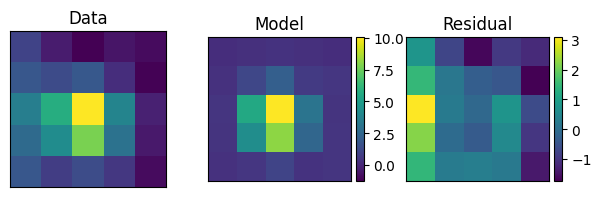

Elapsed Time for Photometry: 86.69279276999987
Starting 3.0  of 4 : <SkyCoord (ICRS): (ra, dec) in deg
    (80.36321461, -69.46265941)>
Setting up sim to match jw01476001007_02101_00001_nrca1_cal.fits


iterating query, tdelta=3.0

MAST OPD query around UTC: 2022-07-11T03:15:34.398
                        MJD: 59771.13581479167

OPD immediately preceding the given datetime:
	URI:	 mast:JWST/product/O2022071001-NRCA3_FP1-0.fits
	Date (MJD):	 59770.4830
	Delta time:	 -0.6529 days

OPD immediately following the given datetime:
	URI:	 mast:JWST/product/R2022071302-NRCA3_FP1-1.fits
	Date (MJD):	 59772.6632
	Delta time:	 1.5274 days
User requested choosing OPD time closest in time to 2022-07-11T03:15:34.398, which is O2022071001-NRCA3_FP1-0.fits, delta time -0.653 days


Importing and format-converting OPD from ./webbpsf-data/webbpsf-data/MAST_JWST_WSS_OPDs/O2022071001-NRCA3_FP1-0.fits
Backing out SI WFE and OTE field dependence at the WF sensing field point



Configured simulation instrument for:
    Instrument: NIRCam
    Filter: F150W
    Detector: NRCA1
    Apername: NRCA1_FULL
    Det. Pos.: (1024, 1024) 
    Image plane mask: None
    Pupil plane mask: None
    

Running instrument: NIRCam, filter: F150W
  Running detector: NRCA1
    Position 1/1: (array(1141.82443535), array(1198.38684371)) pixels


    Position 1/1 centroid: (201.57303705374588, 201.88594564201324)

Running instrument: NIRCam, filter: F150W
  Running detector: NRCA1
    Position 1/1: (array(1931.82110979), array(1986.98575397)) pixels


    Position 1/1 centroid: (201.61259250078294, 201.50747622301395)

Running instrument: NIRCam, filter: F150W
  Running detector: NRCA1
    Position 1/1: (array(364.32495796), array(1989.1279341)) pixels


    Position 1/1 centroid: (201.5494718424865, 201.7437834073172)

Running instrument: NIRCam, filter: F150W
  Running detector: NRCA1
    Position 1/1: (array(353.21841238), array(419.05106284)) pixels


    Position 1/1 centroid: (201.28297377215506, 201.75957337372736)

Running instrument: NIRCam, filter: F150W
  Running detector: NRCA1
    Position 1/1: (array(1923.7539598), array(400.51341239)) pixels


    Position 1/1 centroid: (201.34157196654937, 201.5630448536914)

Running instrument: NIRCam, filter: F150W
  Running detector: NRCA1
    Position 1/1: (array(1929.29431459), array(1193.87883163)) pixels


    Position 1/1 centroid: (201.5950119856974, 201.58348961399062)

Running instrument: NIRCam, filter: F150W
  Running detector: NRCA1
    Position 1/1: (array(1145.31651271), array(1987.60269404)) pixels


    Position 1/1 centroid: (201.59843435533386, 201.87252221096668)

Running instrument: NIRCam, filter: F150W
  Running detector: NRCA1
    Position 1/1: (array(359.92243183), array(1204.15262005)) pixels


    Position 1/1 centroid: (201.47131045801788, 201.74657810754735)

Running instrument: NIRCam, filter: F150W
  Running detector: NRCA1
    Position 1/1: (array(1135.66954108), array(409.03107785)) pixels


    Position 1/1 centroid: (201.3364308865235, 201.79457723493584)


2024-12-10 20:51:11,897 - stpipe.Image3Pipeline - INFO - Image3Pipeline instance created.


2024-12-10 20:51:11,898 - stpipe.Image3Pipeline.assign_mtwcs - INFO - AssignMTWcsStep instance created.


2024-12-10 20:51:11,900 - stpipe.Image3Pipeline.tweakreg - INFO - TweakRegStep instance created.


2024-12-10 20:51:11,902 - stpipe.Image3Pipeline.skymatch - INFO - SkyMatchStep instance created.


2024-12-10 20:51:11,903 - stpipe.Image3Pipeline.outlier_detection - INFO - OutlierDetectionStep instance created.


2024-12-10 20:51:11,905 - stpipe.Image3Pipeline.resample - INFO - ResampleStep instance created.


2024-12-10 20:51:11,906 - stpipe.Image3Pipeline.source_catalog - INFO - SourceCatalogStep instance created.


2024-12-10 20:51:12,064 - stpipe.Image3Pipeline - INFO - Step Image3Pipeline running with args ('./temp_psf_dir/cal_data_asn.json',).


2024-12-10 20:51:12,077 - stpipe.Image3Pipeline - INFO - Step Image3Pipeline parameters are:
  pre_hooks: []
  post_hooks: []
  output_file: None
  output_dir: ./temp_psf_dir
  output_ext: .fits
  output_use_model: False
  output_use_index: True
  save_results: True
  skip: False
  suffix: None
  search_output_file: True
  input_dir: ''
  in_memory: True
  steps:
    assign_mtwcs:
      pre_hooks: []
      post_hooks: []
      output_file: None
      output_dir: None
      output_ext: .fits
      output_use_model: True
      output_use_index: True
      save_results: False
      skip: False
      suffix: assign_mtwcs
      search_output_file: True
      input_dir: ''
    tweakreg:
      pre_hooks: []
      post_hooks: []
      output_file: None
      output_dir: None
      output_ext: .fits
      output_use_model: True
      output_use_index: True
      save_results: False
      skip: True
      suffix: None
      search_output_file: True
      input_dir: ''
      save_catalogs: False


2024-12-10 20:51:12,077 - stpipe.Image3Pipeline - INFO - Starting calwebb_image3 ...


2024-12-10 20:51:12,595 - stpipe.Image3Pipeline.tweakreg - INFO - Step tweakreg running with args (<jwst.datamodels.library.ModelLibrary object at 0x7f3e4e40bf50>,).


2024-12-10 20:51:12,596 - stpipe.Image3Pipeline.tweakreg - INFO - Step skipped.


2024-12-10 20:51:14,605 - stpipe.Image3Pipeline.skymatch - INFO - Step skymatch running with args (<jwst.datamodels.library.ModelLibrary object at 0x7f3e4e40bf50>,).


2024-12-10 20:51:14,606 - stpipe.Image3Pipeline.skymatch - INFO - Step skipped.


2024-12-10 20:51:14,770 - stpipe.Image3Pipeline.outlier_detection - INFO - Step outlier_detection running with args (<jwst.datamodels.library.ModelLibrary object at 0x7f3e4e40bf50>,).


2024-12-10 20:51:14,771 - stpipe.Image3Pipeline.outlier_detection - INFO - Step skipped.


2024-12-10 20:51:14,932 - stpipe.Image3Pipeline.resample - INFO - Step resample running with args (<jwst.datamodels.library.ModelLibrary object at 0x7f3e4e40bf50>,).


2024-12-10 20:51:14,935 - stpipe.Image3Pipeline.resample - WARNING - Mismatched data shapes; skipping invalid data updates for extension 'err'


2024-12-10 20:51:14,935 - stpipe.Image3Pipeline.resample - WARNING - Mismatched data shapes; skipping invalid data updates for extension 'var_rnoise'


2024-12-10 20:51:14,935 - stpipe.Image3Pipeline.resample - WARNING - Mismatched data shapes; skipping invalid data updates for extension 'var_poisson'


2024-12-10 20:51:14,936 - stpipe.Image3Pipeline.resample - WARNING - Mismatched data shapes; skipping invalid data updates for extension 'var_flat'


2024-12-10 20:51:14,941 - stpipe.Image3Pipeline.resample - WARNING - Mismatched data shapes; skipping invalid data updates for extension 'err'


2024-12-10 20:51:14,941 - stpipe.Image3Pipeline.resample - WARNING - Mismatched data shapes; skipping invalid data updates for extension 'var_rnoise'


2024-12-10 20:51:14,942 - stpipe.Image3Pipeline.resample - WARNING - Mismatched data shapes; skipping invalid data updates for extension 'var_poisson'


2024-12-10 20:51:14,942 - stpipe.Image3Pipeline.resample - WARNING - Mismatched data shapes; skipping invalid data updates for extension 'var_flat'


2024-12-10 20:51:14,946 - stpipe.Image3Pipeline.resample - WARNING - Mismatched data shapes; skipping invalid data updates for extension 'err'


2024-12-10 20:51:14,947 - stpipe.Image3Pipeline.resample - WARNING - Mismatched data shapes; skipping invalid data updates for extension 'var_rnoise'


2024-12-10 20:51:14,947 - stpipe.Image3Pipeline.resample - WARNING - Mismatched data shapes; skipping invalid data updates for extension 'var_poisson'


2024-12-10 20:51:14,948 - stpipe.Image3Pipeline.resample - WARNING - Mismatched data shapes; skipping invalid data updates for extension 'var_flat'


2024-12-10 20:51:14,951 - stpipe.Image3Pipeline.resample - WARNING - Mismatched data shapes; skipping invalid data updates for extension 'err'


2024-12-10 20:51:14,952 - stpipe.Image3Pipeline.resample - WARNING - Mismatched data shapes; skipping invalid data updates for extension 'var_rnoise'


2024-12-10 20:51:14,952 - stpipe.Image3Pipeline.resample - WARNING - Mismatched data shapes; skipping invalid data updates for extension 'var_poisson'


2024-12-10 20:51:14,953 - stpipe.Image3Pipeline.resample - WARNING - Mismatched data shapes; skipping invalid data updates for extension 'var_flat'


2024-12-10 20:51:14,957 - stpipe.Image3Pipeline.resample - WARNING - Mismatched data shapes; skipping invalid data updates for extension 'err'


2024-12-10 20:51:14,957 - stpipe.Image3Pipeline.resample - WARNING - Mismatched data shapes; skipping invalid data updates for extension 'var_rnoise'


2024-12-10 20:51:14,958 - stpipe.Image3Pipeline.resample - WARNING - Mismatched data shapes; skipping invalid data updates for extension 'var_poisson'


2024-12-10 20:51:14,959 - stpipe.Image3Pipeline.resample - WARNING - Mismatched data shapes; skipping invalid data updates for extension 'var_flat'


2024-12-10 20:51:14,963 - stpipe.Image3Pipeline.resample - WARNING - Mismatched data shapes; skipping invalid data updates for extension 'err'


2024-12-10 20:51:14,963 - stpipe.Image3Pipeline.resample - WARNING - Mismatched data shapes; skipping invalid data updates for extension 'var_rnoise'


2024-12-10 20:51:14,964 - stpipe.Image3Pipeline.resample - WARNING - Mismatched data shapes; skipping invalid data updates for extension 'var_poisson'


2024-12-10 20:51:14,964 - stpipe.Image3Pipeline.resample - WARNING - Mismatched data shapes; skipping invalid data updates for extension 'var_flat'


2024-12-10 20:51:14,968 - stpipe.Image3Pipeline.resample - WARNING - Mismatched data shapes; skipping invalid data updates for extension 'err'


2024-12-10 20:51:14,968 - stpipe.Image3Pipeline.resample - WARNING - Mismatched data shapes; skipping invalid data updates for extension 'var_rnoise'


2024-12-10 20:51:14,969 - stpipe.Image3Pipeline.resample - WARNING - Mismatched data shapes; skipping invalid data updates for extension 'var_poisson'


2024-12-10 20:51:14,969 - stpipe.Image3Pipeline.resample - WARNING - Mismatched data shapes; skipping invalid data updates for extension 'var_flat'


2024-12-10 20:51:14,973 - stpipe.Image3Pipeline.resample - WARNING - Mismatched data shapes; skipping invalid data updates for extension 'err'


2024-12-10 20:51:14,974 - stpipe.Image3Pipeline.resample - WARNING - Mismatched data shapes; skipping invalid data updates for extension 'var_rnoise'


2024-12-10 20:51:14,974 - stpipe.Image3Pipeline.resample - WARNING - Mismatched data shapes; skipping invalid data updates for extension 'var_poisson'


2024-12-10 20:51:14,975 - stpipe.Image3Pipeline.resample - WARNING - Mismatched data shapes; skipping invalid data updates for extension 'var_flat'


2024-12-10 20:51:14,979 - stpipe.Image3Pipeline.resample - WARNING - Mismatched data shapes; skipping invalid data updates for extension 'err'


2024-12-10 20:51:14,979 - stpipe.Image3Pipeline.resample - WARNING - Mismatched data shapes; skipping invalid data updates for extension 'var_rnoise'


2024-12-10 20:51:14,980 - stpipe.Image3Pipeline.resample - WARNING - Mismatched data shapes; skipping invalid data updates for extension 'var_poisson'


2024-12-10 20:51:14,981 - stpipe.Image3Pipeline.resample - WARNING - Mismatched data shapes; skipping invalid data updates for extension 'var_flat'


2024-12-10 20:51:14,984 - stpipe.Image3Pipeline.resample - INFO - Driz parameter kernel: square


2024-12-10 20:51:14,984 - stpipe.Image3Pipeline.resample - INFO - Driz parameter pixfrac: 1.0


2024-12-10 20:51:14,985 - stpipe.Image3Pipeline.resample - INFO - Driz parameter fillval: NAN


2024-12-10 20:51:14,986 - stpipe.Image3Pipeline.resample - INFO - Driz parameter weight_type: ivm


2024-12-10 20:51:14,986 - stpipe.Image3Pipeline.resample - INFO - Output pixel scale: 0.03122691827458939 arcsec.


2024-12-10 20:51:15,134 - stpipe.Image3Pipeline.resample - INFO - Resampling science data


2024-12-10 20:51:17,191 - stpipe.Image3Pipeline.resample - INFO - Drizzling (2048, 2048) --> (3644, 3643)


2024-12-10 20:51:20,082 - stpipe.Image3Pipeline.resample - INFO - Drizzling (2048, 2048) --> (3644, 3643)


2024-12-10 20:51:22,970 - stpipe.Image3Pipeline.resample - INFO - Drizzling (2048, 2048) --> (3644, 3643)


2024-12-10 20:51:25,860 - stpipe.Image3Pipeline.resample - INFO - Drizzling (2048, 2048) --> (3644, 3643)


2024-12-10 20:51:28,716 - stpipe.Image3Pipeline.resample - INFO - Drizzling (2048, 2048) --> (3644, 3643)


2024-12-10 20:51:31,587 - stpipe.Image3Pipeline.resample - INFO - Drizzling (2048, 2048) --> (3644, 3643)


2024-12-10 20:51:34,515 - stpipe.Image3Pipeline.resample - INFO - Drizzling (2048, 2048) --> (3644, 3643)


2024-12-10 20:51:37,421 - stpipe.Image3Pipeline.resample - INFO - Drizzling (2048, 2048) --> (3644, 3643)


2024-12-10 20:51:40,288 - stpipe.Image3Pipeline.resample - INFO - Drizzling (2048, 2048) --> (3644, 3643)


2024-12-10 20:51:41,528 - stpipe.Image3Pipeline.resample - INFO - Resampling variance components


2024-12-10 20:51:41,564 - stpipe.Image3Pipeline.resample - WARNING - Data shape mismatch for 'var_rnoise' for model 'jw01476001007_02101_00001_nrca1_cal.fits'. Skipping ...


2024-12-10 20:51:41,576 - stpipe.Image3Pipeline.resample - WARNING - Data shape mismatch for 'var_poisson' for model 'jw01476001007_02101_00001_nrca1_cal.fits'. Skipping ...


2024-12-10 20:51:41,577 - stpipe.Image3Pipeline.resample - WARNING - Data shape mismatch for 'var_flat' for model 'jw01476001007_02101_00001_nrca1_cal.fits'. Skipping ...


2024-12-10 20:51:41,578 - stpipe.Image3Pipeline.resample - WARNING - Data shape mismatch for 'var_rnoise' for model 'jw01476001007_02101_00002_nrca1_cal.fits'. Skipping ...


2024-12-10 20:51:41,590 - stpipe.Image3Pipeline.resample - WARNING - Data shape mismatch for 'var_poisson' for model 'jw01476001007_02101_00002_nrca1_cal.fits'. Skipping ...


2024-12-10 20:51:41,591 - stpipe.Image3Pipeline.resample - WARNING - Data shape mismatch for 'var_flat' for model 'jw01476001007_02101_00002_nrca1_cal.fits'. Skipping ...


2024-12-10 20:51:41,591 - stpipe.Image3Pipeline.resample - WARNING - Data shape mismatch for 'var_rnoise' for model 'jw01476001007_02101_00003_nrca1_cal.fits'. Skipping ...


2024-12-10 20:51:41,604 - stpipe.Image3Pipeline.resample - WARNING - Data shape mismatch for 'var_poisson' for model 'jw01476001007_02101_00003_nrca1_cal.fits'. Skipping ...


2024-12-10 20:51:41,604 - stpipe.Image3Pipeline.resample - WARNING - Data shape mismatch for 'var_flat' for model 'jw01476001007_02101_00003_nrca1_cal.fits'. Skipping ...


2024-12-10 20:51:41,605 - stpipe.Image3Pipeline.resample - WARNING - Data shape mismatch for 'var_rnoise' for model 'jw01476001008_02101_00001_nrca1_cal.fits'. Skipping ...


2024-12-10 20:51:41,617 - stpipe.Image3Pipeline.resample - WARNING - Data shape mismatch for 'var_poisson' for model 'jw01476001008_02101_00001_nrca1_cal.fits'. Skipping ...


2024-12-10 20:51:41,618 - stpipe.Image3Pipeline.resample - WARNING - Data shape mismatch for 'var_flat' for model 'jw01476001008_02101_00001_nrca1_cal.fits'. Skipping ...


2024-12-10 20:51:41,619 - stpipe.Image3Pipeline.resample - WARNING - Data shape mismatch for 'var_rnoise' for model 'jw01476001008_02101_00002_nrca1_cal.fits'. Skipping ...


2024-12-10 20:51:41,631 - stpipe.Image3Pipeline.resample - WARNING - Data shape mismatch for 'var_poisson' for model 'jw01476001008_02101_00002_nrca1_cal.fits'. Skipping ...


2024-12-10 20:51:41,632 - stpipe.Image3Pipeline.resample - WARNING - Data shape mismatch for 'var_flat' for model 'jw01476001008_02101_00002_nrca1_cal.fits'. Skipping ...


2024-12-10 20:51:41,633 - stpipe.Image3Pipeline.resample - WARNING - Data shape mismatch for 'var_rnoise' for model 'jw01476001008_02101_00003_nrca1_cal.fits'. Skipping ...


2024-12-10 20:51:41,645 - stpipe.Image3Pipeline.resample - WARNING - Data shape mismatch for 'var_poisson' for model 'jw01476001008_02101_00003_nrca1_cal.fits'. Skipping ...


2024-12-10 20:51:41,646 - stpipe.Image3Pipeline.resample - WARNING - Data shape mismatch for 'var_flat' for model 'jw01476001008_02101_00003_nrca1_cal.fits'. Skipping ...


2024-12-10 20:51:41,647 - stpipe.Image3Pipeline.resample - WARNING - Data shape mismatch for 'var_rnoise' for model 'jw01476001008_02101_00004_nrca1_cal.fits'. Skipping ...


2024-12-10 20:51:41,659 - stpipe.Image3Pipeline.resample - WARNING - Data shape mismatch for 'var_poisson' for model 'jw01476001008_02101_00004_nrca1_cal.fits'. Skipping ...


2024-12-10 20:51:41,659 - stpipe.Image3Pipeline.resample - WARNING - Data shape mismatch for 'var_flat' for model 'jw01476001008_02101_00004_nrca1_cal.fits'. Skipping ...


2024-12-10 20:51:41,660 - stpipe.Image3Pipeline.resample - WARNING - Data shape mismatch for 'var_rnoise' for model 'jw01476001008_02101_00005_nrca1_cal.fits'. Skipping ...


2024-12-10 20:51:41,672 - stpipe.Image3Pipeline.resample - WARNING - Data shape mismatch for 'var_poisson' for model 'jw01476001008_02101_00005_nrca1_cal.fits'. Skipping ...


2024-12-10 20:51:41,673 - stpipe.Image3Pipeline.resample - WARNING - Data shape mismatch for 'var_flat' for model 'jw01476001008_02101_00005_nrca1_cal.fits'. Skipping ...


2024-12-10 20:51:41,674 - stpipe.Image3Pipeline.resample - WARNING - Data shape mismatch for 'var_rnoise' for model 'jw01476001008_02101_00006_nrca1_cal.fits'. Skipping ...


2024-12-10 20:51:41,686 - stpipe.Image3Pipeline.resample - WARNING - Data shape mismatch for 'var_poisson' for model 'jw01476001008_02101_00006_nrca1_cal.fits'. Skipping ...


2024-12-10 20:51:41,687 - stpipe.Image3Pipeline.resample - WARNING - Data shape mismatch for 'var_flat' for model 'jw01476001008_02101_00006_nrca1_cal.fits'. Skipping ...


2024-12-10 20:51:41,878 - stpipe.Image3Pipeline.resample - INFO - Update S_REGION to POLYGON ICRS  80.342792691 -69.439581834 80.299723380 -69.467341703 80.378888523 -69.482445324 80.421885728 -69.454665929


2024-12-10 20:51:42,661 - stpipe.Image3Pipeline.resample - INFO - Saved model in ./temp_psf_dir/temp_psf_cals_i2d.fits


2024-12-10 20:51:42,661 - stpipe.Image3Pipeline.resample - INFO - Step resample done


2024-12-10 20:51:42,834 - stpipe.Image3Pipeline.source_catalog - INFO - Step source_catalog running with args (<ImageModel(3644, 3643) from temp_psf_cals_i2d.fits>,).


2024-12-10 20:51:42,834 - stpipe.Image3Pipeline.source_catalog - INFO - Step skipped.


2024-12-10 20:51:42,841 - stpipe.Image3Pipeline - INFO - Step Image3Pipeline done


2024-12-10 20:51:42,841 - stpipe - INFO - Results used jwst version: 1.16.1


Finished PSF psf_photometry with median residuals of 0.28%


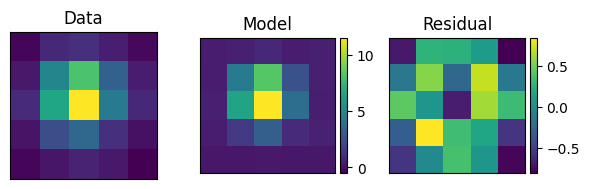

Elapsed Time for Photometry: 85.11499523600014
Starting 4.0  of 4 : <SkyCoord (ICRS): (ra, dec) in deg
    (80.36222499, -69.46259042)>
Setting up sim to match jw01476001007_02101_00001_nrca1_cal.fits


iterating query, tdelta=3.0

MAST OPD query around UTC: 2022-07-11T03:15:34.398
                        MJD: 59771.13581479167

OPD immediately preceding the given datetime:
	URI:	 mast:JWST/product/O2022071001-NRCA3_FP1-0.fits
	Date (MJD):	 59770.4830
	Delta time:	 -0.6529 days

OPD immediately following the given datetime:
	URI:	 mast:JWST/product/R2022071302-NRCA3_FP1-1.fits
	Date (MJD):	 59772.6632
	Delta time:	 1.5274 days
User requested choosing OPD time closest in time to 2022-07-11T03:15:34.398, which is O2022071001-NRCA3_FP1-0.fits, delta time -0.653 days
Importing and format-converting OPD from ./webbpsf-data/webbpsf-data/MAST_JWST_WSS_OPDs/O2022071001-NRCA3_FP1-0.fits


Backing out SI WFE and OTE field dependence at the WF sensing field point



Configured simulation instrument for:
    Instrument: NIRCam
    Filter: F150W
    Detector: NRCA1
    Apername: NRCA1_FULL
    Det. Pos.: (1024, 1024) 
    Image plane mask: None
    Pupil plane mask: None
    

Running instrument: NIRCam, filter: F150W
  Running detector: NRCA1
    Position 1/1: (array(1153.99487077), array(1159.2926373)) pixels


    Position 1/1 centroid: (201.56463155992182, 201.88280411723474)

Running instrument: NIRCam, filter: F150W
  Running detector: NRCA1
    Position 1/1: (array(1944.24611876), array(1947.80227116)) pixels


    Position 1/1 centroid: (201.61797698319637, 201.50257112411626)

Running instrument: NIRCam, filter: F150W
  Running detector: NRCA1
    Position 1/1: (array(376.46659292), array(1950.31790818)) pixels


    Position 1/1 centroid: (201.55392143227127, 201.74305262074068)

Running instrument: NIRCam, filter: F150W
  Running detector: NRCA1
    Position 1/1: (array(365.15354399), array(380.09743534)) pixels


    Position 1/1 centroid: (201.2743514079384, 201.7508588859237)

Running instrument: NIRCam, filter: F150W
  Running detector: NRCA1
    Position 1/1: (array(1935.9053706), array(361.19673061)) pixels


    Position 1/1 centroid: (201.33094458355188, 201.5600391718873)

Running instrument: NIRCam, filter: F150W
  Running detector: NRCA1
    Position 1/1: (array(1941.58612654), array(1154.60816441)) pixels


    Position 1/1 centroid: (201.5860364249192, 201.57997249828063)

Running instrument: NIRCam, filter: F150W
  Running detector: NRCA1
    Position 1/1: (array(1157.60568186), array(1948.60037879)) pixels


    Position 1/1 centroid: (201.60369579506576, 201.8718653462744)

Running instrument: NIRCam, filter: F150W
  Running detector: NRCA1
    Position 1/1: (array(371.96195963), array(1165.25021075)) pixels


    Position 1/1 centroid: (201.46142236440053, 201.74422372983796)

Running instrument: NIRCam, filter: F150W
  Running detector: NRCA1
    Position 1/1: (array(1147.71699541), array(369.88635772)) pixels


    Position 1/1 centroid: (201.32613046894136, 201.78909693815862)


2024-12-10 20:52:38,841 - stpipe.Image3Pipeline - INFO - Image3Pipeline instance created.


2024-12-10 20:52:38,842 - stpipe.Image3Pipeline.assign_mtwcs - INFO - AssignMTWcsStep instance created.


2024-12-10 20:52:38,844 - stpipe.Image3Pipeline.tweakreg - INFO - TweakRegStep instance created.


2024-12-10 20:52:38,846 - stpipe.Image3Pipeline.skymatch - INFO - SkyMatchStep instance created.


2024-12-10 20:52:38,847 - stpipe.Image3Pipeline.outlier_detection - INFO - OutlierDetectionStep instance created.


2024-12-10 20:52:38,849 - stpipe.Image3Pipeline.resample - INFO - ResampleStep instance created.


2024-12-10 20:52:38,850 - stpipe.Image3Pipeline.source_catalog - INFO - SourceCatalogStep instance created.


2024-12-10 20:52:39,007 - stpipe.Image3Pipeline - INFO - Step Image3Pipeline running with args ('./temp_psf_dir/cal_data_asn.json',).


2024-12-10 20:52:39,020 - stpipe.Image3Pipeline - INFO - Step Image3Pipeline parameters are:
  pre_hooks: []
  post_hooks: []
  output_file: None
  output_dir: ./temp_psf_dir
  output_ext: .fits
  output_use_model: False
  output_use_index: True
  save_results: True
  skip: False
  suffix: None
  search_output_file: True
  input_dir: ''
  in_memory: True
  steps:
    assign_mtwcs:
      pre_hooks: []
      post_hooks: []
      output_file: None
      output_dir: None
      output_ext: .fits
      output_use_model: True
      output_use_index: True
      save_results: False
      skip: False
      suffix: assign_mtwcs
      search_output_file: True
      input_dir: ''
    tweakreg:
      pre_hooks: []
      post_hooks: []
      output_file: None
      output_dir: None
      output_ext: .fits
      output_use_model: True
      output_use_index: True
      save_results: False
      skip: True
      suffix: None
      search_output_file: True
      input_dir: ''
      save_catalogs: False


2024-12-10 20:52:39,021 - stpipe.Image3Pipeline - INFO - Starting calwebb_image3 ...


2024-12-10 20:52:39,531 - stpipe.Image3Pipeline.tweakreg - INFO - Step tweakreg running with args (<jwst.datamodels.library.ModelLibrary object at 0x7f3ebaee0950>,).


2024-12-10 20:52:39,532 - stpipe.Image3Pipeline.tweakreg - INFO - Step skipped.


2024-12-10 20:52:41,543 - stpipe.Image3Pipeline.skymatch - INFO - Step skymatch running with args (<jwst.datamodels.library.ModelLibrary object at 0x7f3ebaee0950>,).


2024-12-10 20:52:41,543 - stpipe.Image3Pipeline.skymatch - INFO - Step skipped.


2024-12-10 20:52:41,715 - stpipe.Image3Pipeline.outlier_detection - INFO - Step outlier_detection running with args (<jwst.datamodels.library.ModelLibrary object at 0x7f3ebaee0950>,).


2024-12-10 20:52:41,716 - stpipe.Image3Pipeline.outlier_detection - INFO - Step skipped.


2024-12-10 20:52:41,888 - stpipe.Image3Pipeline.resample - INFO - Step resample running with args (<jwst.datamodels.library.ModelLibrary object at 0x7f3ebaee0950>,).


2024-12-10 20:52:41,890 - stpipe.Image3Pipeline.resample - WARNING - Mismatched data shapes; skipping invalid data updates for extension 'err'


2024-12-10 20:52:41,890 - stpipe.Image3Pipeline.resample - WARNING - Mismatched data shapes; skipping invalid data updates for extension 'var_rnoise'


2024-12-10 20:52:41,891 - stpipe.Image3Pipeline.resample - WARNING - Mismatched data shapes; skipping invalid data updates for extension 'var_poisson'


2024-12-10 20:52:41,891 - stpipe.Image3Pipeline.resample - WARNING - Mismatched data shapes; skipping invalid data updates for extension 'var_flat'


2024-12-10 20:52:41,896 - stpipe.Image3Pipeline.resample - WARNING - Mismatched data shapes; skipping invalid data updates for extension 'err'


2024-12-10 20:52:41,897 - stpipe.Image3Pipeline.resample - WARNING - Mismatched data shapes; skipping invalid data updates for extension 'var_rnoise'


2024-12-10 20:52:41,897 - stpipe.Image3Pipeline.resample - WARNING - Mismatched data shapes; skipping invalid data updates for extension 'var_poisson'


2024-12-10 20:52:41,898 - stpipe.Image3Pipeline.resample - WARNING - Mismatched data shapes; skipping invalid data updates for extension 'var_flat'


2024-12-10 20:52:41,902 - stpipe.Image3Pipeline.resample - WARNING - Mismatched data shapes; skipping invalid data updates for extension 'err'


2024-12-10 20:52:41,902 - stpipe.Image3Pipeline.resample - WARNING - Mismatched data shapes; skipping invalid data updates for extension 'var_rnoise'


2024-12-10 20:52:41,903 - stpipe.Image3Pipeline.resample - WARNING - Mismatched data shapes; skipping invalid data updates for extension 'var_poisson'


2024-12-10 20:52:41,903 - stpipe.Image3Pipeline.resample - WARNING - Mismatched data shapes; skipping invalid data updates for extension 'var_flat'


2024-12-10 20:52:41,907 - stpipe.Image3Pipeline.resample - WARNING - Mismatched data shapes; skipping invalid data updates for extension 'err'


2024-12-10 20:52:41,907 - stpipe.Image3Pipeline.resample - WARNING - Mismatched data shapes; skipping invalid data updates for extension 'var_rnoise'


2024-12-10 20:52:41,908 - stpipe.Image3Pipeline.resample - WARNING - Mismatched data shapes; skipping invalid data updates for extension 'var_poisson'


2024-12-10 20:52:41,908 - stpipe.Image3Pipeline.resample - WARNING - Mismatched data shapes; skipping invalid data updates for extension 'var_flat'


2024-12-10 20:52:41,913 - stpipe.Image3Pipeline.resample - WARNING - Mismatched data shapes; skipping invalid data updates for extension 'err'


2024-12-10 20:52:41,913 - stpipe.Image3Pipeline.resample - WARNING - Mismatched data shapes; skipping invalid data updates for extension 'var_rnoise'


2024-12-10 20:52:41,914 - stpipe.Image3Pipeline.resample - WARNING - Mismatched data shapes; skipping invalid data updates for extension 'var_poisson'


2024-12-10 20:52:41,914 - stpipe.Image3Pipeline.resample - WARNING - Mismatched data shapes; skipping invalid data updates for extension 'var_flat'


2024-12-10 20:52:41,918 - stpipe.Image3Pipeline.resample - WARNING - Mismatched data shapes; skipping invalid data updates for extension 'err'


2024-12-10 20:52:41,918 - stpipe.Image3Pipeline.resample - WARNING - Mismatched data shapes; skipping invalid data updates for extension 'var_rnoise'


2024-12-10 20:52:41,919 - stpipe.Image3Pipeline.resample - WARNING - Mismatched data shapes; skipping invalid data updates for extension 'var_poisson'


2024-12-10 20:52:41,919 - stpipe.Image3Pipeline.resample - WARNING - Mismatched data shapes; skipping invalid data updates for extension 'var_flat'


2024-12-10 20:52:41,924 - stpipe.Image3Pipeline.resample - WARNING - Mismatched data shapes; skipping invalid data updates for extension 'err'


2024-12-10 20:52:41,924 - stpipe.Image3Pipeline.resample - WARNING - Mismatched data shapes; skipping invalid data updates for extension 'var_rnoise'


2024-12-10 20:52:41,925 - stpipe.Image3Pipeline.resample - WARNING - Mismatched data shapes; skipping invalid data updates for extension 'var_poisson'


2024-12-10 20:52:41,925 - stpipe.Image3Pipeline.resample - WARNING - Mismatched data shapes; skipping invalid data updates for extension 'var_flat'


2024-12-10 20:52:41,929 - stpipe.Image3Pipeline.resample - WARNING - Mismatched data shapes; skipping invalid data updates for extension 'err'


2024-12-10 20:52:41,930 - stpipe.Image3Pipeline.resample - WARNING - Mismatched data shapes; skipping invalid data updates for extension 'var_rnoise'


2024-12-10 20:52:41,930 - stpipe.Image3Pipeline.resample - WARNING - Mismatched data shapes; skipping invalid data updates for extension 'var_poisson'


2024-12-10 20:52:41,931 - stpipe.Image3Pipeline.resample - WARNING - Mismatched data shapes; skipping invalid data updates for extension 'var_flat'


2024-12-10 20:52:41,935 - stpipe.Image3Pipeline.resample - WARNING - Mismatched data shapes; skipping invalid data updates for extension 'err'


2024-12-10 20:52:41,935 - stpipe.Image3Pipeline.resample - WARNING - Mismatched data shapes; skipping invalid data updates for extension 'var_rnoise'


2024-12-10 20:52:41,936 - stpipe.Image3Pipeline.resample - WARNING - Mismatched data shapes; skipping invalid data updates for extension 'var_poisson'


2024-12-10 20:52:41,936 - stpipe.Image3Pipeline.resample - WARNING - Mismatched data shapes; skipping invalid data updates for extension 'var_flat'


2024-12-10 20:52:41,940 - stpipe.Image3Pipeline.resample - INFO - Driz parameter kernel: square


2024-12-10 20:52:41,940 - stpipe.Image3Pipeline.resample - INFO - Driz parameter pixfrac: 1.0


2024-12-10 20:52:41,941 - stpipe.Image3Pipeline.resample - INFO - Driz parameter fillval: NAN


2024-12-10 20:52:41,941 - stpipe.Image3Pipeline.resample - INFO - Driz parameter weight_type: ivm


2024-12-10 20:52:41,942 - stpipe.Image3Pipeline.resample - INFO - Output pixel scale: 0.03122691827458939 arcsec.


2024-12-10 20:52:42,089 - stpipe.Image3Pipeline.resample - INFO - Resampling science data


2024-12-10 20:52:44,172 - stpipe.Image3Pipeline.resample - INFO - Drizzling (2048, 2048) --> (3644, 3643)


2024-12-10 20:52:47,059 - stpipe.Image3Pipeline.resample - INFO - Drizzling (2048, 2048) --> (3644, 3643)


2024-12-10 20:52:49,965 - stpipe.Image3Pipeline.resample - INFO - Drizzling (2048, 2048) --> (3644, 3643)


2024-12-10 20:52:52,861 - stpipe.Image3Pipeline.resample - INFO - Drizzling (2048, 2048) --> (3644, 3643)


2024-12-10 20:52:55,747 - stpipe.Image3Pipeline.resample - INFO - Drizzling (2048, 2048) --> (3644, 3643)


2024-12-10 20:52:58,617 - stpipe.Image3Pipeline.resample - INFO - Drizzling (2048, 2048) --> (3644, 3643)


2024-12-10 20:53:01,522 - stpipe.Image3Pipeline.resample - INFO - Drizzling (2048, 2048) --> (3644, 3643)


2024-12-10 20:53:04,416 - stpipe.Image3Pipeline.resample - INFO - Drizzling (2048, 2048) --> (3644, 3643)


2024-12-10 20:53:07,301 - stpipe.Image3Pipeline.resample - INFO - Drizzling (2048, 2048) --> (3644, 3643)


2024-12-10 20:53:08,534 - stpipe.Image3Pipeline.resample - INFO - Resampling variance components


2024-12-10 20:53:08,569 - stpipe.Image3Pipeline.resample - WARNING - Data shape mismatch for 'var_rnoise' for model 'jw01476001007_02101_00001_nrca1_cal.fits'. Skipping ...


2024-12-10 20:53:08,582 - stpipe.Image3Pipeline.resample - WARNING - Data shape mismatch for 'var_poisson' for model 'jw01476001007_02101_00001_nrca1_cal.fits'. Skipping ...


2024-12-10 20:53:08,582 - stpipe.Image3Pipeline.resample - WARNING - Data shape mismatch for 'var_flat' for model 'jw01476001007_02101_00001_nrca1_cal.fits'. Skipping ...


2024-12-10 20:53:08,583 - stpipe.Image3Pipeline.resample - WARNING - Data shape mismatch for 'var_rnoise' for model 'jw01476001007_02101_00002_nrca1_cal.fits'. Skipping ...


2024-12-10 20:53:08,596 - stpipe.Image3Pipeline.resample - WARNING - Data shape mismatch for 'var_poisson' for model 'jw01476001007_02101_00002_nrca1_cal.fits'. Skipping ...


2024-12-10 20:53:08,596 - stpipe.Image3Pipeline.resample - WARNING - Data shape mismatch for 'var_flat' for model 'jw01476001007_02101_00002_nrca1_cal.fits'. Skipping ...


2024-12-10 20:53:08,597 - stpipe.Image3Pipeline.resample - WARNING - Data shape mismatch for 'var_rnoise' for model 'jw01476001007_02101_00003_nrca1_cal.fits'. Skipping ...


2024-12-10 20:53:08,609 - stpipe.Image3Pipeline.resample - WARNING - Data shape mismatch for 'var_poisson' for model 'jw01476001007_02101_00003_nrca1_cal.fits'. Skipping ...


2024-12-10 20:53:08,610 - stpipe.Image3Pipeline.resample - WARNING - Data shape mismatch for 'var_flat' for model 'jw01476001007_02101_00003_nrca1_cal.fits'. Skipping ...


2024-12-10 20:53:08,611 - stpipe.Image3Pipeline.resample - WARNING - Data shape mismatch for 'var_rnoise' for model 'jw01476001008_02101_00001_nrca1_cal.fits'. Skipping ...


2024-12-10 20:53:08,623 - stpipe.Image3Pipeline.resample - WARNING - Data shape mismatch for 'var_poisson' for model 'jw01476001008_02101_00001_nrca1_cal.fits'. Skipping ...


2024-12-10 20:53:08,624 - stpipe.Image3Pipeline.resample - WARNING - Data shape mismatch for 'var_flat' for model 'jw01476001008_02101_00001_nrca1_cal.fits'. Skipping ...


2024-12-10 20:53:08,625 - stpipe.Image3Pipeline.resample - WARNING - Data shape mismatch for 'var_rnoise' for model 'jw01476001008_02101_00002_nrca1_cal.fits'. Skipping ...


2024-12-10 20:53:08,637 - stpipe.Image3Pipeline.resample - WARNING - Data shape mismatch for 'var_poisson' for model 'jw01476001008_02101_00002_nrca1_cal.fits'. Skipping ...


2024-12-10 20:53:08,637 - stpipe.Image3Pipeline.resample - WARNING - Data shape mismatch for 'var_flat' for model 'jw01476001008_02101_00002_nrca1_cal.fits'. Skipping ...


2024-12-10 20:53:08,638 - stpipe.Image3Pipeline.resample - WARNING - Data shape mismatch for 'var_rnoise' for model 'jw01476001008_02101_00003_nrca1_cal.fits'. Skipping ...


2024-12-10 20:53:08,651 - stpipe.Image3Pipeline.resample - WARNING - Data shape mismatch for 'var_poisson' for model 'jw01476001008_02101_00003_nrca1_cal.fits'. Skipping ...


2024-12-10 20:53:08,651 - stpipe.Image3Pipeline.resample - WARNING - Data shape mismatch for 'var_flat' for model 'jw01476001008_02101_00003_nrca1_cal.fits'. Skipping ...


2024-12-10 20:53:08,652 - stpipe.Image3Pipeline.resample - WARNING - Data shape mismatch for 'var_rnoise' for model 'jw01476001008_02101_00004_nrca1_cal.fits'. Skipping ...


2024-12-10 20:53:08,665 - stpipe.Image3Pipeline.resample - WARNING - Data shape mismatch for 'var_poisson' for model 'jw01476001008_02101_00004_nrca1_cal.fits'. Skipping ...


2024-12-10 20:53:08,666 - stpipe.Image3Pipeline.resample - WARNING - Data shape mismatch for 'var_flat' for model 'jw01476001008_02101_00004_nrca1_cal.fits'. Skipping ...


2024-12-10 20:53:08,666 - stpipe.Image3Pipeline.resample - WARNING - Data shape mismatch for 'var_rnoise' for model 'jw01476001008_02101_00005_nrca1_cal.fits'. Skipping ...


2024-12-10 20:53:08,679 - stpipe.Image3Pipeline.resample - WARNING - Data shape mismatch for 'var_poisson' for model 'jw01476001008_02101_00005_nrca1_cal.fits'. Skipping ...


2024-12-10 20:53:08,679 - stpipe.Image3Pipeline.resample - WARNING - Data shape mismatch for 'var_flat' for model 'jw01476001008_02101_00005_nrca1_cal.fits'. Skipping ...


2024-12-10 20:53:08,680 - stpipe.Image3Pipeline.resample - WARNING - Data shape mismatch for 'var_rnoise' for model 'jw01476001008_02101_00006_nrca1_cal.fits'. Skipping ...


2024-12-10 20:53:08,692 - stpipe.Image3Pipeline.resample - WARNING - Data shape mismatch for 'var_poisson' for model 'jw01476001008_02101_00006_nrca1_cal.fits'. Skipping ...


2024-12-10 20:53:08,693 - stpipe.Image3Pipeline.resample - WARNING - Data shape mismatch for 'var_flat' for model 'jw01476001008_02101_00006_nrca1_cal.fits'. Skipping ...


2024-12-10 20:53:08,884 - stpipe.Image3Pipeline.resample - INFO - Update S_REGION to POLYGON ICRS  80.342792691 -69.439581834 80.299723380 -69.467341703 80.378888523 -69.482445324 80.421885728 -69.454665929


2024-12-10 20:53:09,662 - stpipe.Image3Pipeline.resample - INFO - Saved model in ./temp_psf_dir/temp_psf_cals_i2d.fits


2024-12-10 20:53:09,663 - stpipe.Image3Pipeline.resample - INFO - Step resample done


2024-12-10 20:53:09,837 - stpipe.Image3Pipeline.source_catalog - INFO - Step source_catalog running with args (<ImageModel(3644, 3643) from temp_psf_cals_i2d.fits>,).


2024-12-10 20:53:09,838 - stpipe.Image3Pipeline.source_catalog - INFO - Step skipped.


2024-12-10 20:53:09,844 - stpipe.Image3Pipeline - INFO - Step Image3Pipeline done


2024-12-10 20:53:09,844 - stpipe - INFO - Results used jwst version: 1.16.1


Finished PSF psf_photometry with median residuals of 0.48%


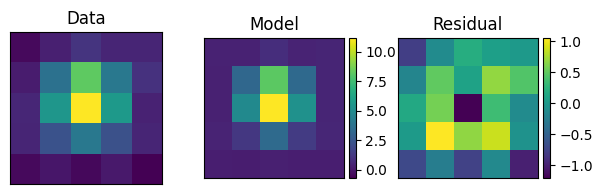

Elapsed Time for Photometry: 87.05056423199994


In [37]:
# Now Loop Through All Stars and Build Photometry Table
counter = 0.
badindex = []

for source_location in skycoords:
    tic = time.perf_counter()
    print('Starting', counter+1., ' of', len(skycoords), ':', source_location)
    psf3 = space_phot.get_jwst3_psf(jwst_obs, jwst3_obs, source_location, num_psfs=4)
    jwst3_obs.psf_photometry(
        psf3,
        source_location,
        bounds={
            'flux': [-1000, 10000],
            'centroid': [-2, 2],
            'bkg': [0, 50]
        },
        fit_width=5,
        fit_bkg=True,
        fit_flux=True
    )

    jwst3_obs.plot_psf_fit()
    plt.show()

    ra = jwst3_obs.psf_result.phot_cal_table['ra'][0]
    dec = jwst3_obs.psf_result.phot_cal_table['dec'][0]
    mag_lvl3psf = jwst3_obs.psf_result.phot_cal_table['mag'][0]
    magerr_lvl3psf = jwst3_obs.psf_result.phot_cal_table['magerr'][0]

    if counter == 0:
        df = pd.DataFrame(np.array([[ra, dec, mag_lvl3psf, magerr_lvl3psf]]), columns=['ra', 'dec', 'mag', 'magerr'])
    else:
        df = pd.concat([df, pd.DataFrame(np.array([[ra, dec, mag_lvl3psf, magerr_lvl3psf]]))], ignore_index=True)
    counter = counter + 1.
    toc = time.perf_counter()
    print("Elapsed Time for Photometry:", toc - tic)

<hr style="border:1px solid gray"> </hr>

<img style="float: center;" src="https://raw.githubusercontent.com/spacetelescope/notebooks/master/assets/stsci_pri_combo_mark_horizonal_white_bkgd.png" alt="Space Telescope Logo" width="200px"/>